In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

Using TensorFlow backend.


In [2]:
# Load the data
current_path = os.getcwd()
file = '\\datasets\\credit_card_data\\credit_card.csv'
data = pd.read_csv(current_path + file)

In [3]:
dataX = data.copy().drop(['Class','Time'],axis=1)

In [4]:
dataY = data['Class'].copy()

In [5]:
# Scale data

In [6]:
featuresToScale = dataX.columns

In [7]:
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

In [8]:
# Split into train and test

In [9]:
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY)

In [10]:
X_train_AE = X_train.copy()
X_test_AE = X_test.copy()

In [ ]:
# Define evaluation function and plotting function

In [11]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [12]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

In [11]:
# Model one
# Two layer complete autoencoder with linear activation

In [32]:
# Call neural network API
model = Sequential()

# Apply linear activation function to input layer
# Generate hidden layer with 29 nodes, the same as the input layer
model.add(Dense(units=29, activation='linear',input_dim=29))

# Apply linear activation function to hidden layer
# Generate output layer with 29 nodes
model.add(Dense(units=29, activation='linear'))

In [33]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [34]:
# Train the model
num_epochs = 10
batch_size = 32

history = model.fit(x=X_train_AE, y=X_train_AE,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_train_AE, X_train_AE),
                    verbose=1)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 19s 97us/step - loss: 0.0875 - acc: 0.8813 - val_loss: 0.0013 - val_acc: 0.9910
Epoch 2/10
190820/190820 [==============================] - 21s 110us/step - loss: 0.0013 - acc: 0.9906 - val_loss: 7.4468e-06 - val_acc: 0.9993
Epoch 3/10
190820/190820 [==============================] - 21s 112us/step - loss: 8.4630e-04 - acc: 0.9938 - val_loss: 1.0943e-04 - val_acc: 0.9965
Epoch 4/10
190820/190820 [==============================] - 22s 117us/step - loss: 8.2266e-04 - acc: 0.9935 - val_loss: 2.3293e-04 - val_acc: 0.9946
Epoch 5/10
190820/190820 [==============================] - 22s 115us/step - loss: 4.0126e-04 - acc: 0.9952 - val_loss: 4.3294e-04 - val_acc: 0.9944
Epoch 6/10
190820/190820 [==============================] - 21s 112us/step - loss: 6.8034e-04 - acc: 0.9941 - val_loss: 2.3419e-05 - val_acc: 0.9987
Epoch 7/10
190820/190820 [==============================] - 22s 116

93987/93987 [==============================] - 2s 24us/step


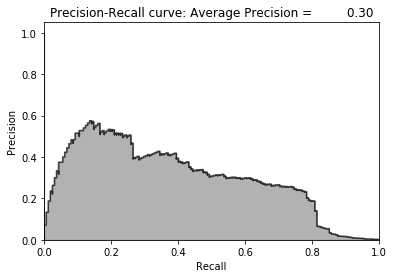

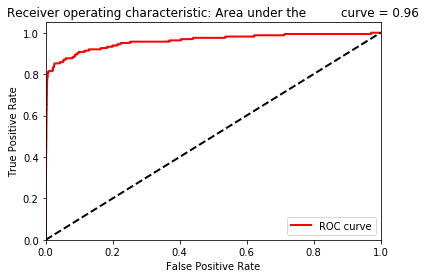

In [36]:
# Evaluate on test set
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)
model.reset_states()

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 23s 118us/step - loss: 0.0720 - acc: 0.9083 - val_loss: 2.3982e-04 - val_acc: 0.9946
Epoch 2/10
190820/190820 [==============================] - 24s 128us/step - loss: 5.6052e-04 - acc: 0.9948 - val_loss: 4.5736e-10 - val_acc: 1.0000
Epoch 3/10
190820/190820 [==============================] - 25s 129us/step - loss: 8.0721e-04 - acc: 0.9928 - val_loss: 5.8911e-04 - val_acc: 0.9867
Epoch 4/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0012 - acc: 0.9941 - val_loss: 5.6138e-04 - val_acc: 0.9873
Epoch 5/10
190820/190820 [==============================] - 24s 127us/step - loss: 4.4006e-04 - acc: 0.9956 - val_loss: 4.2703e-05 - val_acc: 0.9979
Epoch 6/10
190820/190820 [==============================] - 24s 125us/step - loss: 5.9096e-04 - acc: 0.9946 - val_loss: 4.7794e-06 - val_acc: 0.9994
Epoch 7/10
190820/190820 [==============================] - 24

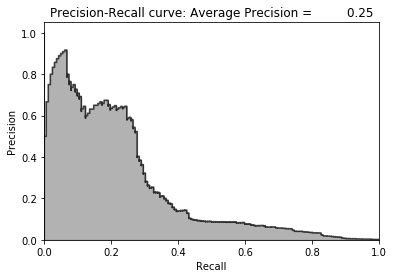

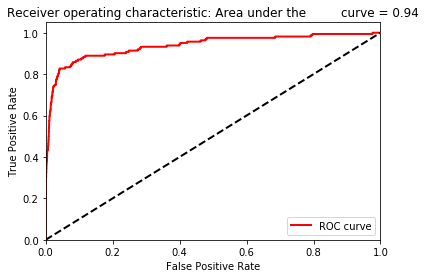

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 110us/step - loss: 0.0907 - acc: 0.8871 - val_loss: 0.0011 - val_acc: 0.9898
Epoch 2/10
190820/190820 [==============================] - 20s 107us/step - loss: 0.0010 - acc: 0.9926 - val_loss: 1.3100e-05 - val_acc: 0.9976
Epoch 3/10
190820/190820 [==============================] - 20s 106us/step - loss: 8.5268e-04 - acc: 0.9942 - val_loss: 5.1731e-04 - val_acc: 0.9903
Epoch 4/10
190820/190820 [==============================] - 20s 106us/step - loss: 5.8230e-04 - acc: 0.9938 - val_loss: 6.7704e-05 - val_acc: 0.9962
Epoch 5/10
190820/190820 [==============================] - 20s 106us/step - loss: 4.5038e-04 - acc: 0.9948 - val_loss: 0.0020 - val_acc: 0.9792
Epoch 6/10
190820/190820 [==============================] - 21s 107us/step - loss: 5.8920e-04 - acc: 0.9948 - val_loss: 4.2774e-08 - val_acc: 0.9999
Epoch 7/10
190820/190820 [==============================] - 20s 106us/

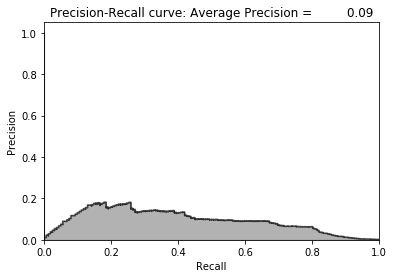

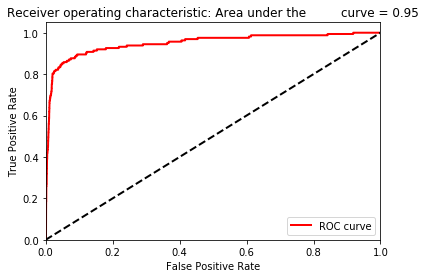

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 109us/step - loss: 0.0809 - acc: 0.8931 - val_loss: 0.0012 - val_acc: 0.9845
Epoch 2/10
190820/190820 [==============================] - 20s 106us/step - loss: 6.9445e-04 - acc: 0.9934 - val_loss: 7.4391e-04 - val_acc: 0.9981
Epoch 3/10
190820/190820 [==============================] - 20s 106us/step - loss: 0.0011 - acc: 0.9941 - val_loss: 5.7408e-06 - val_acc: 0.9987
Epoch 4/10
190820/190820 [==============================] - 20s 106us/step - loss: 5.1486e-04 - acc: 0.9958 - val_loss: 3.1255e-04 - val_acc: 0.9932
Epoch 5/10
190820/190820 [==============================] - 20s 106us/step - loss: 6.7245e-04 - acc: 0.9937 - val_loss: 6.1240e-04 - val_acc: 0.9890
Epoch 6/10
190820/190820 [==============================] - 20s 106us/step - loss: 5.2501e-04 - acc: 0.9952 - val_loss: 3.6349e-05 - val_acc: 0.9970
Epoch 7/10
190820/190820 [==============================] - 20s 10

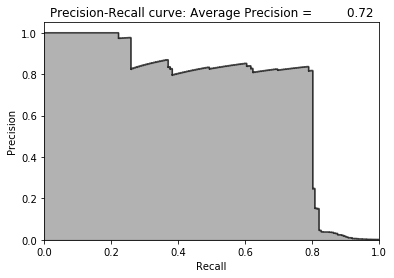

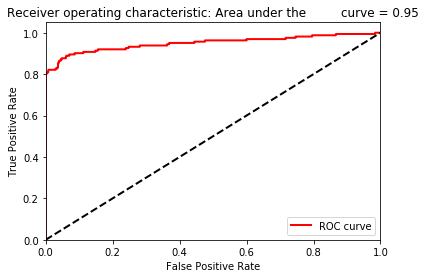

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 109us/step - loss: 0.0803 - acc: 0.8916 - val_loss: 0.0016 - val_acc: 0.9905
Epoch 2/10
190820/190820 [==============================] - 20s 107us/step - loss: 0.0012 - acc: 0.9900 - val_loss: 5.4181e-04 - val_acc: 0.9944
Epoch 3/10
190820/190820 [==============================] - 20s 107us/step - loss: 5.7874e-04 - acc: 0.9942 - val_loss: 1.4244e-04 - val_acc: 0.9943
Epoch 4/10
190820/190820 [==============================] - 20s 107us/step - loss: 6.6773e-04 - acc: 0.9935 - val_loss: 0.0020 - val_acc: 0.9874
Epoch 5/10
190820/190820 [==============================] - 20s 107us/step - loss: 4.5810e-04 - acc: 0.9940 - val_loss: 6.2743e-04 - val_acc: 0.9960
Epoch 6/10
190820/190820 [==============================] - 20s 107us/step - loss: 4.7294e-04 - acc: 0.9954 - val_loss: 0.0022 - val_acc: 0.9918
Epoch 7/10
190820/190820 [==============================] - 20s 107us/step

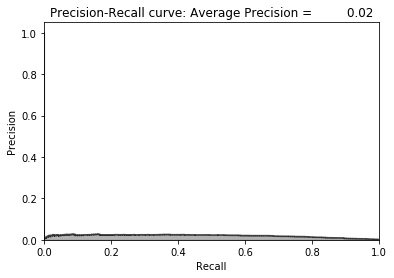

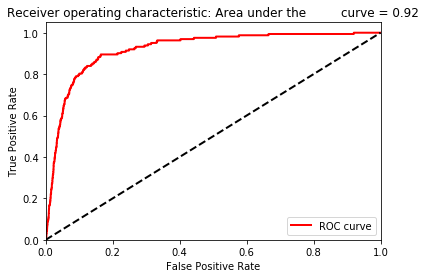

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 111us/step - loss: 0.0737 - acc: 0.9084 - val_loss: 0.0012 - val_acc: 0.9890
Epoch 2/10
190820/190820 [==============================] - 21s 108us/step - loss: 8.8271e-04 - acc: 0.9915 - val_loss: 5.2248e-05 - val_acc: 0.9961
Epoch 3/10
190820/190820 [==============================] - 21s 108us/step - loss: 6.1246e-04 - acc: 0.9941 - val_loss: 9.9391e-06 - val_acc: 0.9980
Epoch 4/10
190820/190820 [==============================] - 21s 108us/step - loss: 6.7619e-04 - acc: 0.9943 - val_loss: 0.0010 - val_acc: 0.9863
Epoch 5/10
190820/190820 [==============================] - 21s 110us/step - loss: 5.6907e-04 - acc: 0.9952 - val_loss: 0.0010 - val_acc: 0.9935
Epoch 6/10
190820/190820 [==============================] - 21s 108us/step - loss: 5.7038e-04 - acc: 0.9949 - val_loss: 0.0015 - val_acc: 0.9868
Epoch 7/10
190820/190820 [==============================] - 21s 108us/step

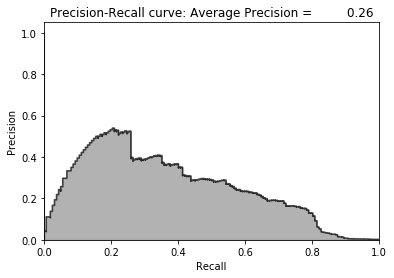

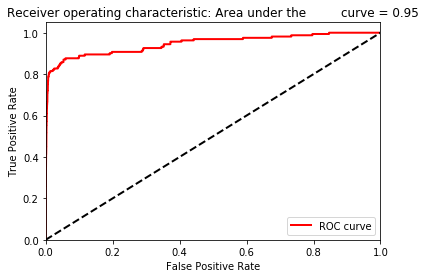

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 112us/step - loss: 0.0830 - acc: 0.8984 - val_loss: 0.0016 - val_acc: 0.9865
Epoch 2/10
190820/190820 [==============================] - 21s 108us/step - loss: 9.1874e-04 - acc: 0.9918 - val_loss: 4.0249e-05 - val_acc: 0.9979
Epoch 3/10
190820/190820 [==============================] - 21s 109us/step - loss: 5.7444e-04 - acc: 0.9947 - val_loss: 7.4180e-07 - val_acc: 0.9998
Epoch 4/10
190820/190820 [==============================] - 21s 109us/step - loss: 8.4245e-04 - acc: 0.9936 - val_loss: 1.4854e-04 - val_acc: 0.9960
Epoch 5/10
190820/190820 [==============================] - 21s 108us/step - loss: 7.0105e-04 - acc: 0.9955 - val_loss: 1.8347e-05 - val_acc: 0.9976
Epoch 6/10
190820/190820 [==============================] - 21s 109us/step - loss: 6.5456e-04 - acc: 0.9943 - val_loss: 3.3865e-05 - val_acc: 0.9978
Epoch 7/10
190820/190820 [==============================] - 21

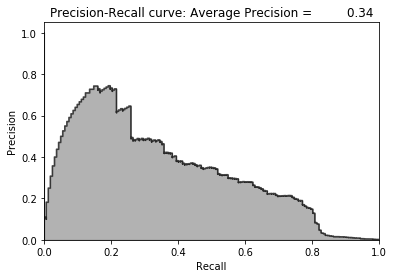

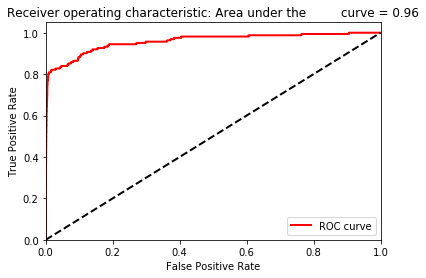

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 112us/step - loss: 0.0812 - acc: 0.8960 - val_loss: 0.0017 - val_acc: 0.9884
Epoch 2/10
190820/190820 [==============================] - 21s 109us/step - loss: 0.0019 - acc: 0.9870 - val_loss: 1.1240e-04 - val_acc: 0.9950
Epoch 3/10
190820/190820 [==============================] - 21s 110us/step - loss: 7.4372e-04 - acc: 0.9928 - val_loss: 0.0019 - val_acc: 0.9858
Epoch 4/10
190820/190820 [==============================] - 21s 109us/step - loss: 5.6676e-04 - acc: 0.9942 - val_loss: 1.1766e-05 - val_acc: 0.9993
Epoch 5/10
190820/190820 [==============================] - 21s 108us/step - loss: 5.1856e-04 - acc: 0.9942 - val_loss: 2.5847e-05 - val_acc: 0.9980
Epoch 6/10
190820/190820 [==============================] - 21s 109us/step - loss: 6.8052e-04 - acc: 0.9947 - val_loss: 0.0015 - val_acc: 0.9867
Epoch 7/10
190820/190820 [==============================] - 21s 109us/step

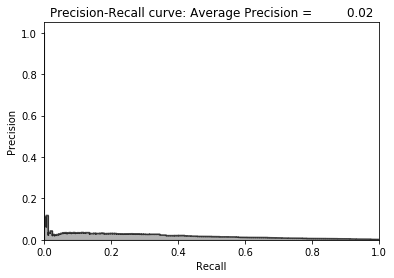

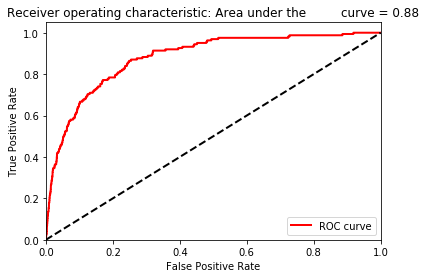

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 22s 113us/step - loss: 0.0851 - acc: 0.8891 - val_loss: 0.0012 - val_acc: 0.9884
Epoch 2/10
190820/190820 [==============================] - 21s 109us/step - loss: 9.1127e-04 - acc: 0.9913 - val_loss: 0.0027 - val_acc: 0.9782
Epoch 3/10
190820/190820 [==============================] - 21s 110us/step - loss: 6.7707e-04 - acc: 0.9936 - val_loss: 0.0016 - val_acc: 0.9882
Epoch 4/10
190820/190820 [==============================] - 21s 109us/step - loss: 5.0584e-04 - acc: 0.9944 - val_loss: 9.2344e-06 - val_acc: 0.9990
Epoch 5/10
190820/190820 [==============================] - 21s 109us/step - loss: 5.9377e-04 - acc: 0.9935 - val_loss: 1.3101e-04 - val_acc: 0.9963
Epoch 6/10
190820/190820 [==============================] - 21s 109us/step - loss: 4.8722e-04 - acc: 0.9944 - val_loss: 4.6424e-05 - val_acc: 0.9954
Epoch 7/10
190820/190820 [==============================] - 21s 109us/

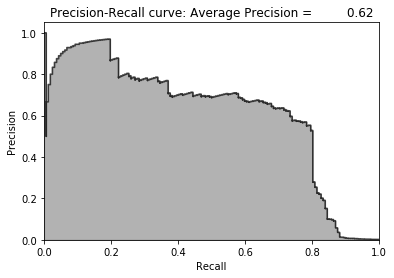

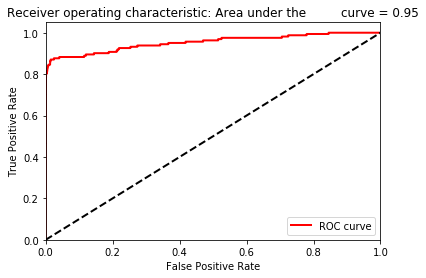

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 22s 113us/step - loss: 0.1280 - acc: 0.8450 - val_loss: 0.0019 - val_acc: 0.9865
Epoch 2/10
190820/190820 [==============================] - 21s 109us/step - loss: 0.0017 - acc: 0.9871 - val_loss: 8.6679e-06 - val_acc: 0.9987
Epoch 3/10
190820/190820 [==============================] - 21s 109us/step - loss: 6.8045e-04 - acc: 0.9941 - val_loss: 1.0954e-04 - val_acc: 0.9939
Epoch 4/10
190820/190820 [==============================] - 21s 110us/step - loss: 6.2994e-04 - acc: 0.9941 - val_loss: 0.0075 - val_acc: 0.9614
Epoch 5/10
190820/190820 [==============================] - 21s 109us/step - loss: 6.5508e-04 - acc: 0.9949 - val_loss: 7.7230e-07 - val_acc: 0.9997
Epoch 6/10
190820/190820 [==============================] - 21s 109us/step - loss: 5.8706e-04 - acc: 0.9935 - val_loss: 2.4177e-06 - val_acc: 0.9995
Epoch 7/10
190820/190820 [==============================] - 21s 109us/

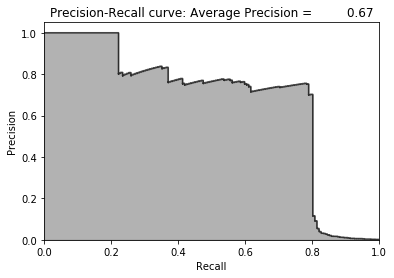

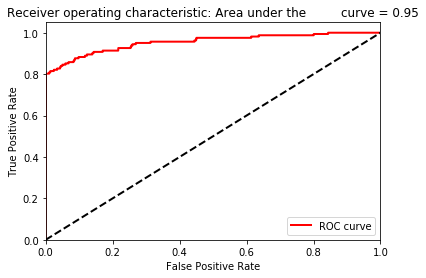

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 22s 114us/step - loss: 0.1093 - acc: 0.8582 - val_loss: 0.0012 - val_acc: 0.9882
Epoch 2/10
190820/190820 [==============================] - 21s 110us/step - loss: 8.1089e-04 - acc: 0.9913 - val_loss: 1.0684e-04 - val_acc: 0.9971
Epoch 3/10
190820/190820 [==============================] - 21s 110us/step - loss: 6.2176e-04 - acc: 0.9949 - val_loss: 1.3835e-06 - val_acc: 0.9995
Epoch 4/10
190820/190820 [==============================] - 21s 111us/step - loss: 6.0330e-04 - acc: 0.9936 - val_loss: 2.4142e-04 - val_acc: 0.9977
Epoch 5/10
190820/190820 [==============================] - 21s 111us/step - loss: 7.3907e-04 - acc: 0.9935 - val_loss: 6.2895e-07 - val_acc: 0.9997
Epoch 6/10
190820/190820 [==============================] - 21s 112us/step - loss: 5.5046e-04 - acc: 0.9939 - val_loss: 3.0635e-05 - val_acc: 0.9982
Epoch 7/10
190820/190820 [==============================] - 21

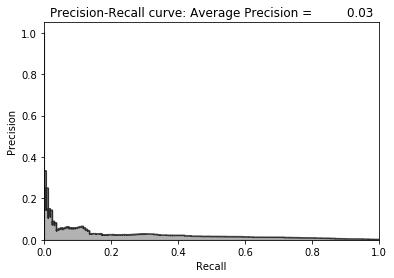

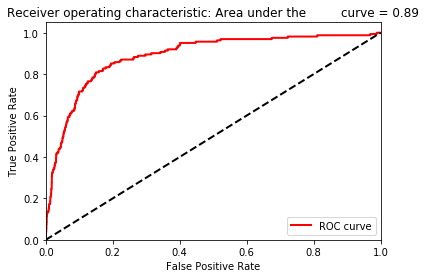

In [29]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 29 nodes, the same as the input layer
    model.add(Dense(units=29, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [43]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.30108318944579776
Coefficient of variation over 10 runs:  0.8755095071789248


[0.25468022666666157,
 0.092705950994909,
 0.716481644928299,
 0.01946589342639965,
 0.25623865457838263,
 0.33597083510378234,
 0.018757053070824415,
 0.6188569400568724,
 0.6720556247581304,
 0.025619070873716072]

In [44]:
# Model two
# Two layer undercomplete autoencoder with linear activation
# With 20 nodes in hidden layer

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 20 nodes
    model.add(Dense(units=20, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [ ]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

In [ ]:
# Model two v2
# Two layer undercomplete autoencoder with linear activation
# With 27 nodes this time

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.1080 - acc: 0.8262 - val_loss: 0.0371 - val_acc: 0.8764
Epoch 2/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0397 - acc: 0.9078 - val_loss: 0.0355 - val_acc: 0.9038
Epoch 3/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0378 - acc: 0.9177 - val_loss: 0.0349 - val_acc: 0.9209
Epoch 4/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.0374 - acc: 0.9303 - val_loss: 0.0344 - val_acc: 0.9325
Epoch 5/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0358 - acc: 0.9518 - val_loss: 0.0340 - val_acc: 0.9507
Epoch 6/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0369 - acc: 0.9383 - val_loss: 0.0338 - val_acc: 0.9575
Epoch 7/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0356 - acc: 0.958

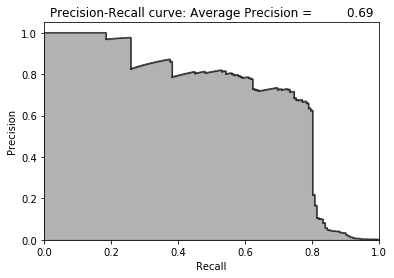

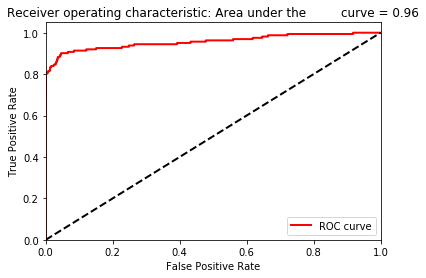

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 135us/step - loss: 0.1173 - acc: 0.8099 - val_loss: 0.0365 - val_acc: 0.9082
Epoch 2/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0380 - acc: 0.8919 - val_loss: 0.0353 - val_acc: 0.9237
Epoch 3/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0368 - acc: 0.9433 - val_loss: 0.0342 - val_acc: 0.9434
Epoch 4/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0370 - acc: 0.9397 - val_loss: 0.0350 - val_acc: 0.9534
Epoch 5/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0357 - acc: 0.9535 - val_loss: 0.0339 - val_acc: 0.9509
Epoch 6/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0351 - acc: 0.9566 - val_loss: 0.0345 - val_acc: 0.9247
Epoch 7/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0356 - acc: 0.952

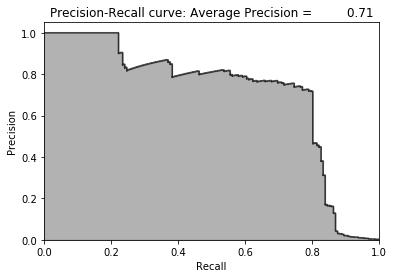

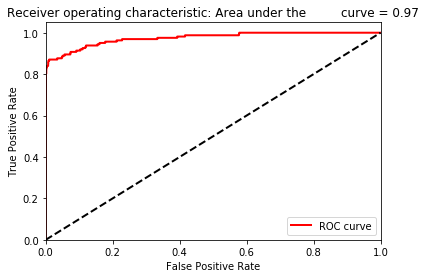

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 134us/step - loss: 0.1105 - acc: 0.7929 - val_loss: 0.0362 - val_acc: 0.8685
Epoch 2/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0384 - acc: 0.8988 - val_loss: 0.0360 - val_acc: 0.8872
Epoch 3/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0372 - acc: 0.8996 - val_loss: 0.0356 - val_acc: 0.9227
Epoch 4/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0371 - acc: 0.9205 - val_loss: 0.0349 - val_acc: 0.9134
Epoch 5/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0361 - acc: 0.9162 - val_loss: 0.0341 - val_acc: 0.9451
Epoch 6/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0351 - acc: 0.9532 - val_loss: 0.0351 - val_acc: 0.9369
Epoch 7/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0371 - acc: 0.941

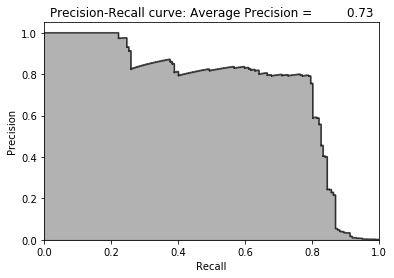

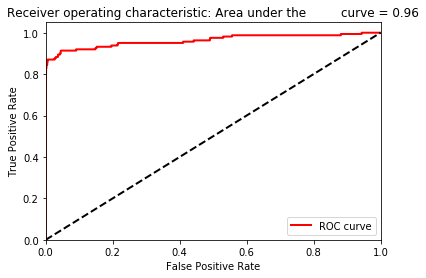

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 134us/step - loss: 0.1221 - acc: 0.7986 - val_loss: 0.0364 - val_acc: 0.8837
Epoch 2/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0398 - acc: 0.8844 - val_loss: 0.0362 - val_acc: 0.8702
Epoch 3/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0391 - acc: 0.8944 - val_loss: 0.0391 - val_acc: 0.9064
Epoch 4/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0377 - acc: 0.9215 - val_loss: 0.0352 - val_acc: 0.9217
Epoch 5/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0389 - acc: 0.9325 - val_loss: 0.0361 - val_acc: 0.9547
Epoch 6/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0376 - acc: 0.9444 - val_loss: 0.0352 - val_acc: 0.9562
Epoch 7/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0383 - acc: 0.948

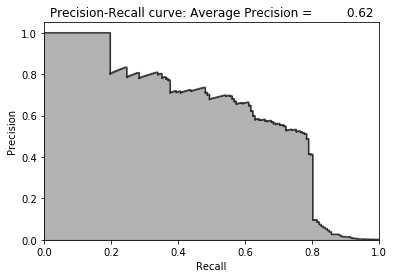

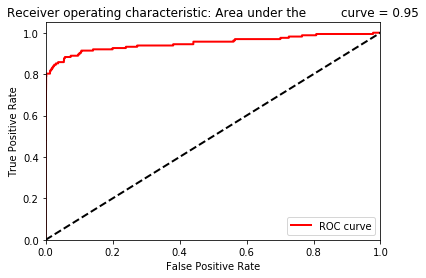

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.1146 - acc: 0.8148 - val_loss: 0.0362 - val_acc: 0.8775
Epoch 2/10
190820/190820 [==============================] - 25s 128us/step - loss: 0.0380 - acc: 0.9128 - val_loss: 0.0362 - val_acc: 0.9300
Epoch 3/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0373 - acc: 0.9398 - val_loss: 0.0342 - val_acc: 0.9564
Epoch 4/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0356 - acc: 0.9489 - val_loss: 0.0352 - val_acc: 0.9365
Epoch 5/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0358 - acc: 0.9499 - val_loss: 0.0343 - val_acc: 0.9623
Epoch 6/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0358 - acc: 0.9664 - val_loss: 0.0347 - val_acc: 0.9643
Epoch 7/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0360 - acc: 0.953

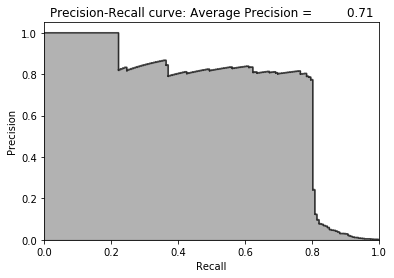

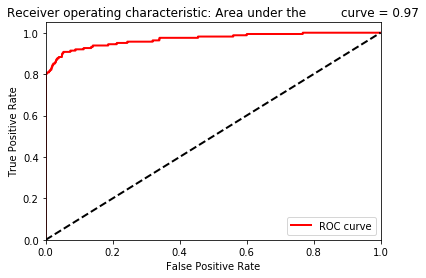

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.1219 - acc: 0.8111 - val_loss: 0.0358 - val_acc: 0.8733
Epoch 2/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0398 - acc: 0.9045 - val_loss: 0.0352 - val_acc: 0.9045
Epoch 3/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0385 - acc: 0.9360 - val_loss: 0.0356 - val_acc: 0.9347
Epoch 4/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0388 - acc: 0.9420 - val_loss: 0.0354 - val_acc: 0.9445
Epoch 5/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0385 - acc: 0.9489 - val_loss: 0.0353 - val_acc: 0.9355
Epoch 6/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0381 - acc: 0.9419 - val_loss: 0.0371 - val_acc: 0.9411
Epoch 7/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0378 - acc: 0.944

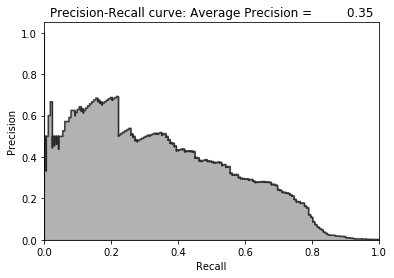

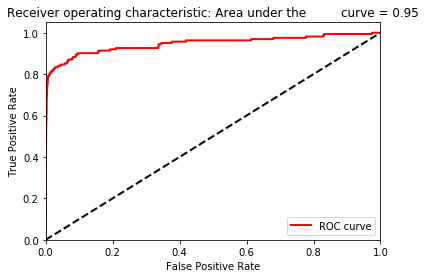

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.1078 - acc: 0.8263 - val_loss: 0.0349 - val_acc: 0.9107
Epoch 2/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0380 - acc: 0.9188 - val_loss: 0.0462 - val_acc: 0.9075
Epoch 3/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0360 - acc: 0.9385 - val_loss: 0.0362 - val_acc: 0.9391
Epoch 4/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0355 - acc: 0.9515 - val_loss: 0.0368 - val_acc: 0.9407
Epoch 5/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0366 - acc: 0.9445 - val_loss: 0.0346 - val_acc: 0.9528
Epoch 6/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0360 - acc: 0.9502 - val_loss: 0.0339 - val_acc: 0.9697
Epoch 7/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0360 - acc: 0.951

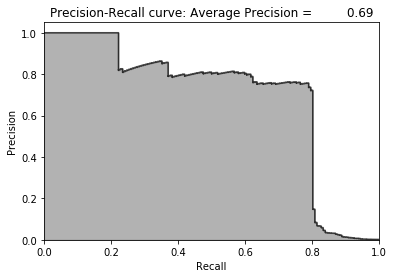

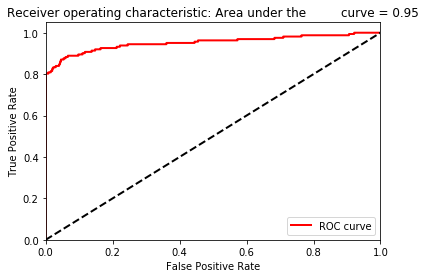

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.1175 - acc: 0.7919 - val_loss: 0.0375 - val_acc: 0.8796
Epoch 2/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0404 - acc: 0.8767 - val_loss: 0.0365 - val_acc: 0.9072
Epoch 3/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0395 - acc: 0.9225 - val_loss: 0.0370 - val_acc: 0.9276
Epoch 4/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0400 - acc: 0.9411 - val_loss: 0.0367 - val_acc: 0.9471
Epoch 5/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0389 - acc: 0.9521 - val_loss: 0.0367 - val_acc: 0.9478
Epoch 6/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0391 - acc: 0.9544 - val_loss: 0.0369 - val_acc: 0.9619
Epoch 7/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0392 - acc: 0.959

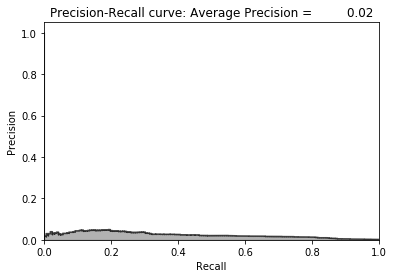

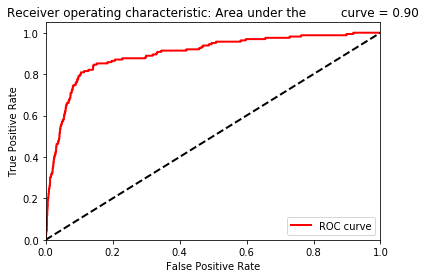

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.1039 - acc: 0.8526 - val_loss: 0.0362 - val_acc: 0.8903
Epoch 2/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0389 - acc: 0.9055 - val_loss: 0.0356 - val_acc: 0.9173
Epoch 3/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0369 - acc: 0.9165 - val_loss: 0.0351 - val_acc: 0.9197
Epoch 4/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0378 - acc: 0.9273 - val_loss: 0.0365 - val_acc: 0.9167
Epoch 5/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0370 - acc: 0.9294 - val_loss: 0.0345 - val_acc: 0.9454
Epoch 6/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0362 - acc: 0.9398 - val_loss: 0.0343 - val_acc: 0.9453
Epoch 7/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0360 - acc: 0.948

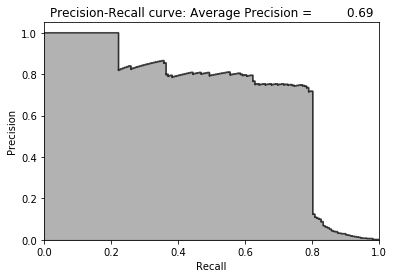

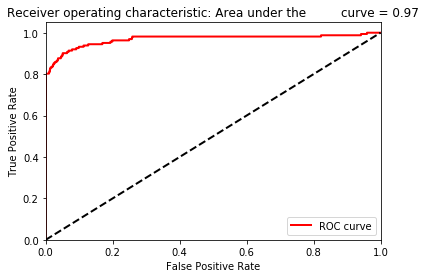

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.1527 - acc: 0.7974 - val_loss: 0.0365 - val_acc: 0.8876
Epoch 2/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0389 - acc: 0.8878 - val_loss: 0.0364 - val_acc: 0.8870
Epoch 3/10
190820/190820 [==============================] - 26s 134us/step - loss: 0.0398 - acc: 0.8946 - val_loss: 0.0365 - val_acc: 0.9104
Epoch 4/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0389 - acc: 0.9364 - val_loss: 0.0381 - val_acc: 0.9420
Epoch 5/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0389 - acc: 0.9552 - val_loss: 0.0365 - val_acc: 0.9631
Epoch 6/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0383 - acc: 0.9603 - val_loss: 0.0368 - val_acc: 0.9610
Epoch 7/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0389 - acc: 0.955

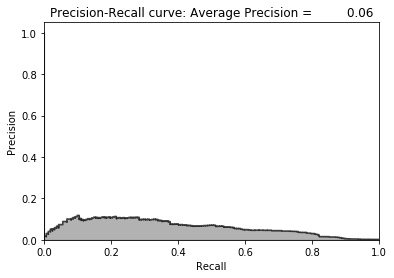

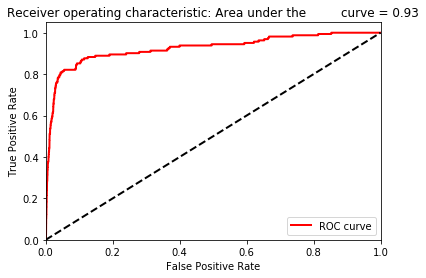

Mean average precision over 10 runs:  0.5273341559141779


[0.689799495450694,
 0.7092146840717755,
 0.7336692377321005,
 0.6154173765950426,
 0.7068800243349335,
 0.35250757724667586,
 0.6904117414832501,
 0.02335388808244066,
 0.690798140588336,
 0.061289393556529626]

In [50]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 27 nodes
    model.add(Dense(units=27, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [51]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.5273341559141779
Coefficient of variation over 10 runs:  0.5006880691999009


[0.689799495450694,
 0.7092146840717755,
 0.7336692377321005,
 0.6154173765950426,
 0.7068800243349335,
 0.35250757724667586,
 0.6904117414832501,
 0.02335388808244066,
 0.690798140588336,
 0.061289393556529626]

In [52]:
# Model three
# Three layer undercomplete autoencoder with linear activation
# With 28 and 27 nodes in the two hidden layers, respectively

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 162us/step - loss: 0.1177 - acc: 0.8226 - val_loss: 0.0369 - val_acc: 0.9168
Epoch 2/10
190820/190820 [==============================] - 46s 241us/step - loss: 0.0390 - acc: 0.9161 - val_loss: 0.0387 - val_acc: 0.9339
Epoch 3/10
190820/190820 [==============================] - 50s 260us/step - loss: 0.0402 - acc: 0.9491 - val_loss: 0.0368 - val_acc: 0.9582
Epoch 4/10
190820/190820 [==============================] - 39s 202us/step - loss: 0.0396 - acc: 0.9523 - val_loss: 0.0368 - val_acc: 0.9611
Epoch 5/10
190820/190820 [==============================] - 36s 188us/step - loss: 0.0392 - acc: 0.9577 - val_loss: 0.0383 - val_acc: 0.9609
Epoch 6/10
190820/190820 [==============================] - 34s 180us/step - loss: 0.0396 - acc: 0.9631 - val_loss: 0.0368 - val_acc: 0.9695
Epoch 7/10
190820/190820 [==============================] - 33s 175us/step - loss: 0.0392 - acc: 0.959

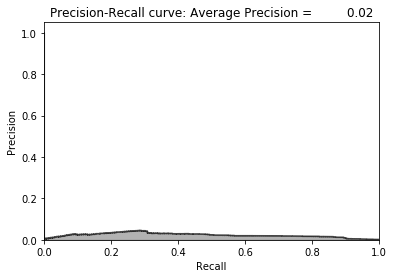

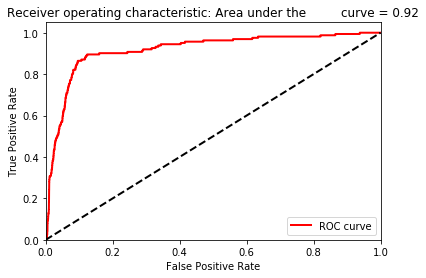

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 33s 172us/step - loss: 0.1124 - acc: 0.8086 - val_loss: 0.0358 - val_acc: 0.9040
Epoch 2/10
190820/190820 [==============================] - 32s 166us/step - loss: 0.0379 - acc: 0.8986 - val_loss: 0.0350 - val_acc: 0.9320
Epoch 3/10
190820/190820 [==============================] - 31s 163us/step - loss: 0.0367 - acc: 0.9400 - val_loss: 0.0349 - val_acc: 0.9464
Epoch 4/10
190820/190820 [==============================] - 32s 167us/step - loss: 0.0367 - acc: 0.9510 - val_loss: 0.0339 - val_acc: 0.9718
Epoch 5/10
190820/190820 [==============================] - 29s 152us/step - loss: 0.0352 - acc: 0.9547 - val_loss: 0.0347 - val_acc: 0.9324
Epoch 6/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.0362 - acc: 0.9567 - val_loss: 0.0346 - val_acc: 0.9552
Epoch 7/10
190820/190820 [==============================] - 29s 152us/step - loss: 0.0364 - acc: 0.953

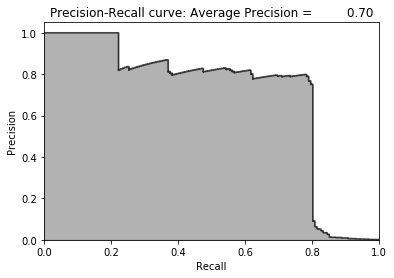

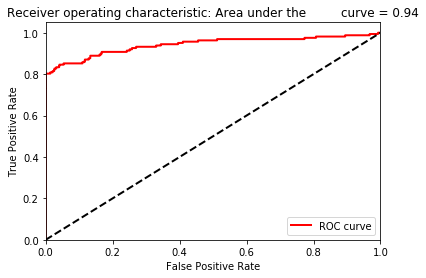

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.1242 - acc: 0.8100 - val_loss: 0.0364 - val_acc: 0.8877
Epoch 2/10
190820/190820 [==============================] - 29s 150us/step - loss: 0.0384 - acc: 0.8880 - val_loss: 0.0360 - val_acc: 0.8985
Epoch 3/10
190820/190820 [==============================] - 29s 150us/step - loss: 0.0406 - acc: 0.9233 - val_loss: 0.0366 - val_acc: 0.9414
Epoch 4/10
190820/190820 [==============================] - 29s 153us/step - loss: 0.0387 - acc: 0.9335 - val_loss: 0.0416 - val_acc: 0.9523
Epoch 5/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.0408 - acc: 0.9518 - val_loss: 0.0367 - val_acc: 0.9514
Epoch 6/10
190820/190820 [==============================] - 29s 151us/step - loss: 0.0387 - acc: 0.9548 - val_loss: 0.0372 - val_acc: 0.9534
Epoch 7/10
190820/190820 [==============================] - 29s 151us/step - loss: 0.0396 - acc: 0.953

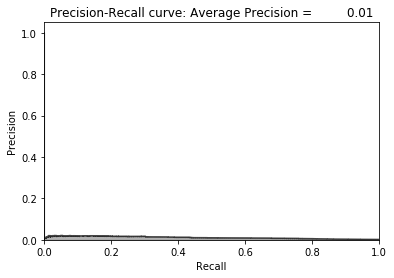

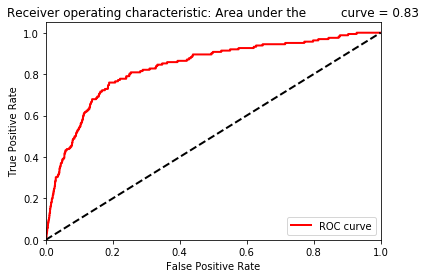

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 160us/step - loss: 0.1578 - acc: 0.7536 - val_loss: 0.0377 - val_acc: 0.8973
Epoch 2/10
190820/190820 [==============================] - 30s 157us/step - loss: 0.0391 - acc: 0.9081 - val_loss: 0.0359 - val_acc: 0.9233
Epoch 3/10
190820/190820 [==============================] - 29s 153us/step - loss: 0.0414 - acc: 0.9410 - val_loss: 0.0394 - val_acc: 0.9345
Epoch 4/10
190820/190820 [==============================] - 29s 152us/step - loss: 0.0391 - acc: 0.9502 - val_loss: 0.0358 - val_acc: 0.9485
Epoch 5/10
190820/190820 [==============================] - 29s 153us/step - loss: 0.0392 - acc: 0.9459 - val_loss: 0.0357 - val_acc: 0.9495
Epoch 6/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.0392 - acc: 0.9486 - val_loss: 0.0369 - val_acc: 0.9553
Epoch 7/10
190820/190820 [==============================] - 29s 153us/step - loss: 0.0402 - acc: 0.952

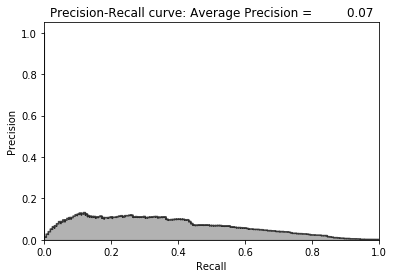

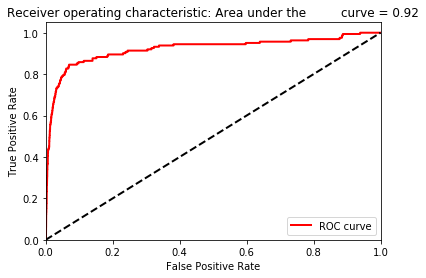

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 36s 188us/step - loss: 0.1577 - acc: 0.7651 - val_loss: 0.0381 - val_acc: 0.8981
Epoch 2/10
190820/190820 [==============================] - 32s 166us/step - loss: 0.0388 - acc: 0.9177 - val_loss: 0.0372 - val_acc: 0.9272
Epoch 3/10
190820/190820 [==============================] - 32s 167us/step - loss: 0.0404 - acc: 0.9392 - val_loss: 0.0364 - val_acc: 0.9442
Epoch 4/10
190820/190820 [==============================] - 31s 162us/step - loss: 0.0398 - acc: 0.9421 - val_loss: 0.0362 - val_acc: 0.9474
Epoch 5/10
190820/190820 [==============================] - 30s 159us/step - loss: 0.0397 - acc: 0.9503 - val_loss: 0.0370 - val_acc: 0.9584
Epoch 6/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.0392 - acc: 0.9594 - val_loss: 0.0371 - val_acc: 0.9619
Epoch 7/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.0393 - acc: 0.960

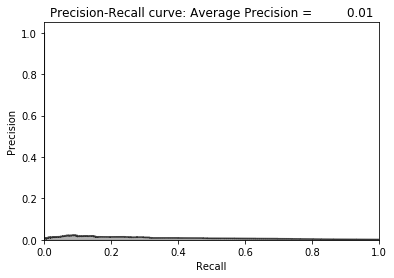

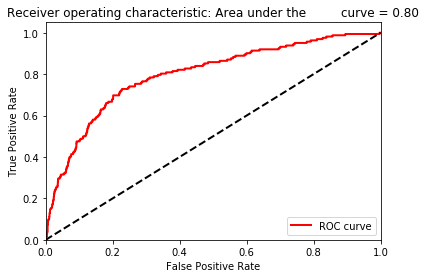

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 164us/step - loss: 0.1263 - acc: 0.7935 - val_loss: 0.0421 - val_acc: 0.8621
Epoch 2/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.0388 - acc: 0.8670 - val_loss: 0.0397 - val_acc: 0.8857
Epoch 3/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.0378 - acc: 0.8984 - val_loss: 0.0345 - val_acc: 0.9202
Epoch 4/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.0366 - acc: 0.9265 - val_loss: 0.0343 - val_acc: 0.9442
Epoch 5/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.0359 - acc: 0.9436 - val_loss: 0.0343 - val_acc: 0.9495
Epoch 6/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.0367 - acc: 0.9412 - val_loss: 0.0340 - val_acc: 0.9638
Epoch 7/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.0357 - acc: 0.952

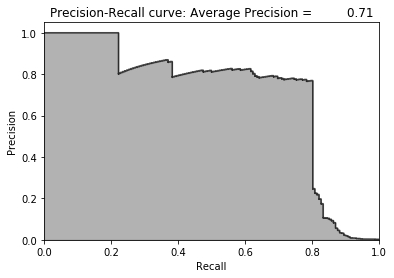

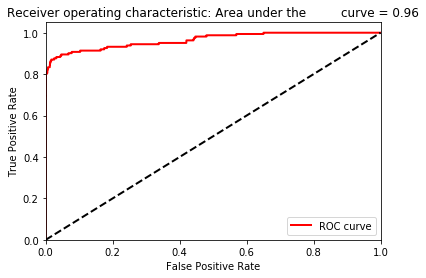

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 162us/step - loss: 0.1275 - acc: 0.8001 - val_loss: 0.0415 - val_acc: 0.8850
Epoch 2/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.0387 - acc: 0.9070 - val_loss: 0.0349 - val_acc: 0.9181
Epoch 3/10
190820/190820 [==============================] - 32s 167us/step - loss: 0.0386 - acc: 0.9199 - val_loss: 0.0345 - val_acc: 0.9320
Epoch 4/10
190820/190820 [==============================] - 32s 166us/step - loss: 0.0367 - acc: 0.9371 - val_loss: 0.0346 - val_acc: 0.9421
Epoch 5/10
190820/190820 [==============================] - 30s 157us/step - loss: 0.0355 - acc: 0.9452 - val_loss: 0.0345 - val_acc: 0.9541
Epoch 6/10
190820/190820 [==============================] - 30s 159us/step - loss: 0.0363 - acc: 0.9574 - val_loss: 0.0345 - val_acc: 0.9451
Epoch 7/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.0384 - acc: 0.899

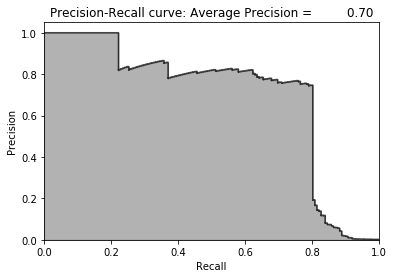

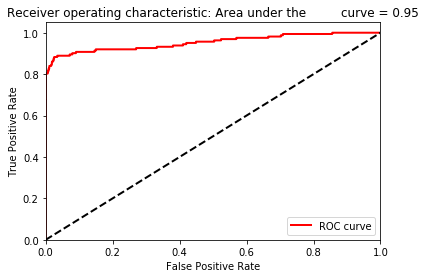

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 33s 172us/step - loss: 0.1338 - acc: 0.7893 - val_loss: 0.0370 - val_acc: 0.8984
Epoch 2/10
190820/190820 [==============================] - 30s 159us/step - loss: 0.0411 - acc: 0.9126 - val_loss: 0.0362 - val_acc: 0.9315
Epoch 3/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.0400 - acc: 0.9270 - val_loss: 0.0359 - val_acc: 0.9266
Epoch 4/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.0393 - acc: 0.9322 - val_loss: 0.0361 - val_acc: 0.9397
Epoch 5/10
190820/190820 [==============================] - 30s 159us/step - loss: 0.0388 - acc: 0.9390 - val_loss: 0.0361 - val_acc: 0.9322
Epoch 6/10
190820/190820 [==============================] - 30s 157us/step - loss: 0.0390 - acc: 0.9380 - val_loss: 0.0367 - val_acc: 0.9283
Epoch 7/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.0379 - acc: 0.929

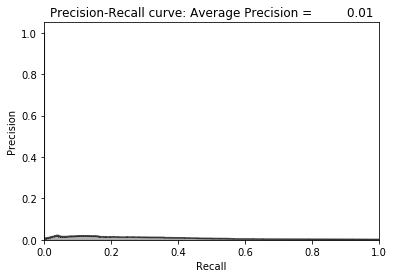

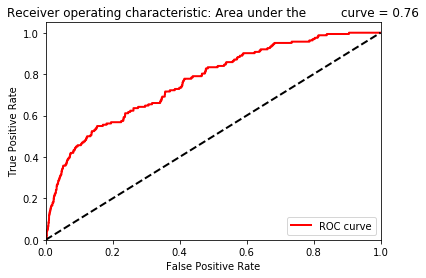

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 167us/step - loss: 0.0996 - acc: 0.8256 - val_loss: 0.0351 - val_acc: 0.9029
Epoch 2/10
190820/190820 [==============================] - 30s 159us/step - loss: 0.0368 - acc: 0.9252 - val_loss: 0.0356 - val_acc: 0.9105
Epoch 3/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.0369 - acc: 0.9359 - val_loss: 0.0345 - val_acc: 0.9475
Epoch 4/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.0356 - acc: 0.9421 - val_loss: 0.0348 - val_acc: 0.9269
Epoch 5/10
190820/190820 [==============================] - 32s 166us/step - loss: 0.0365 - acc: 0.9338 - val_loss: 0.0346 - val_acc: 0.9395
Epoch 6/10
190820/190820 [==============================] - 31s 160us/step - loss: 0.0365 - acc: 0.9461 - val_loss: 0.0338 - val_acc: 0.9632
Epoch 7/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.0355 - acc: 0.955

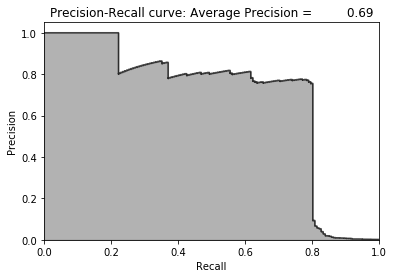

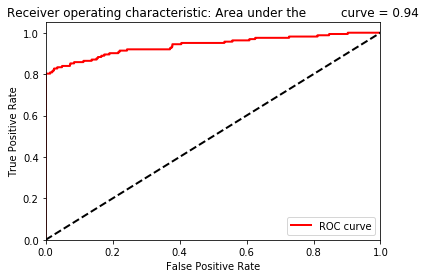

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 166us/step - loss: 0.1336 - acc: 0.7906 - val_loss: 0.0359 - val_acc: 0.8915
Epoch 2/10
190820/190820 [==============================] - 31s 161us/step - loss: 0.0390 - acc: 0.8993 - val_loss: 0.0350 - val_acc: 0.8997
Epoch 3/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.0372 - acc: 0.9040 - val_loss: 0.0361 - val_acc: 0.9263
Epoch 4/10
190820/190820 [==============================] - 30s 159us/step - loss: 0.0358 - acc: 0.9508 - val_loss: 0.0349 - val_acc: 0.9374
Epoch 5/10
190820/190820 [==============================] - 30s 159us/step - loss: 0.0365 - acc: 0.9527 - val_loss: 0.0340 - val_acc: 0.9566
Epoch 6/10
190820/190820 [==============================] - 31s 162us/step - loss: 0.0358 - acc: 0.9544 - val_loss: 0.0342 - val_acc: 0.9616
Epoch 7/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.0354 - acc: 0.962

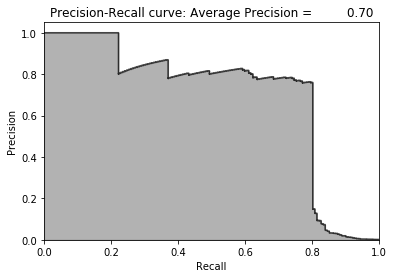

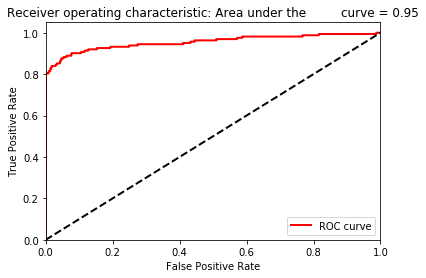

Mean average precision over 10 runs:  0.36075271075596366


[0.02259626054852924,
 0.6984699403560997,
 0.011035001202665167,
 0.06621450000830197,
 0.008916986608776182,
 0.705399684020873,
 0.6995233144849828,
 0.008263068338243631,
 0.6904537524978872,
 0.6966545994932775]

In [53]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 28 nodes
    model.add(Dense(units=28, activation='linear',input_dim=29))
    model.add(Dense(units=27, activation='linear'))

    # Apply linear activation function to second hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [54]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.36075271075596366
Coefficient of variation over 10 runs:  0.9361649046827353


[0.02259626054852924,
 0.6984699403560997,
 0.011035001202665167,
 0.06621450000830197,
 0.008916986608776182,
 0.705399684020873,
 0.6995233144849828,
 0.008263068338243631,
 0.6904537524978872,
 0.6966545994932775]

In [55]:
# Model four
# Four layer undercomplete autoencoder with ReLu activation
# 29 -> 27 -> 22 -> 27 -> 29

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.6767 - acc: 0.6501 - val_loss: 0.6221 - val_acc: 0.7759
Epoch 2/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.5991 - acc: 0.8112 - val_loss: 0.5938 - val_acc: 0.8076
Epoch 3/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.5884 - acc: 0.8318 - val_loss: 0.5790 - val_acc: 0.8567
Epoch 4/10
190820/190820 [==============================] - 30s 159us/step - loss: 0.5808 - acc: 0.8444 - val_loss: 0.5763 - val_acc: 0.8662
Epoch 5/10
190820/190820 [==============================] - 31s 164us/step - loss: 0.5799 - acc: 0.8478 - val_loss: 0.5760 - val_acc: 0.8637
Epoch 6/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.5776 - acc: 0.8483 - val_loss: 0.5748 - val_acc: 0.8571
Epoch 7/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.5760 - acc: 0.852

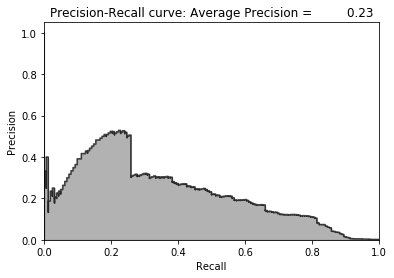

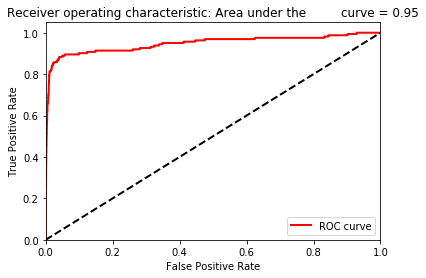

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 164us/step - loss: 0.7306 - acc: 0.5588 - val_loss: 0.6762 - val_acc: 0.6628
Epoch 2/10
190820/190820 [==============================] - 31s 160us/step - loss: 0.6556 - acc: 0.7300 - val_loss: 0.6462 - val_acc: 0.7529
Epoch 3/10
190820/190820 [==============================] - 31s 163us/step - loss: 0.6239 - acc: 0.7628 - val_loss: 0.6121 - val_acc: 0.7846
Epoch 4/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.6100 - acc: 0.7800 - val_loss: 0.6087 - val_acc: 0.7671
Epoch 5/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.6060 - acc: 0.7916 - val_loss: 0.6031 - val_acc: 0.8029
Epoch 6/10
190820/190820 [==============================] - 31s 161us/step - loss: 0.6051 - acc: 0.7931 - val_loss: 0.6020 - val_acc: 0.7985
Epoch 7/10
190820/190820 [==============================] - 31s 163us/step - loss: 0.6167 - acc: 0.769

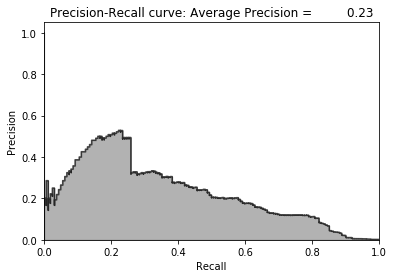

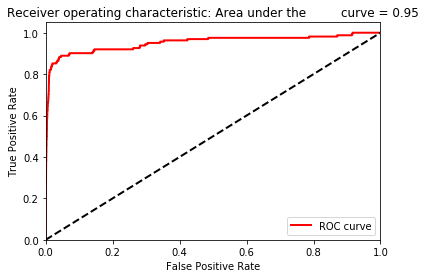

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 30s 157us/step - loss: 0.7090 - acc: 0.6184 - val_loss: 0.6491 - val_acc: 0.7324
Epoch 2/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.6343 - acc: 0.7781 - val_loss: 0.6213 - val_acc: 0.7977
Epoch 3/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.6187 - acc: 0.7994 - val_loss: 0.6143 - val_acc: 0.8148
Epoch 4/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.6147 - acc: 0.8015 - val_loss: 0.6084 - val_acc: 0.8140
Epoch 5/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.6099 - acc: 0.8132 - val_loss: 0.6076 - val_acc: 0.8122
Epoch 6/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.6097 - acc: 0.8205 - val_loss: 0.6054 - val_acc: 0.8391
Epoch 7/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.6076 - acc: 0.822

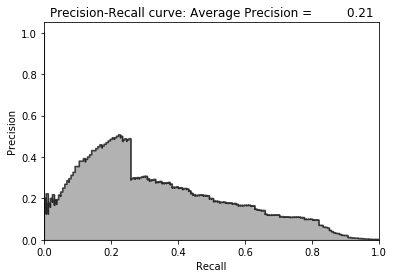

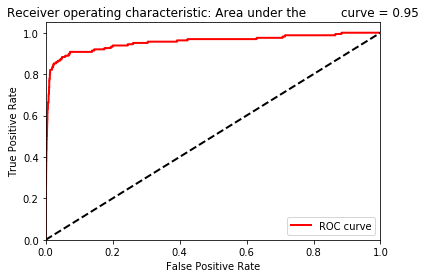

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 160us/step - loss: 0.6918 - acc: 0.6084 - val_loss: 0.6142 - val_acc: 0.7753
Epoch 2/10
190820/190820 [==============================] - 30s 157us/step - loss: 0.6062 - acc: 0.7898 - val_loss: 0.5970 - val_acc: 0.7907
Epoch 3/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.5924 - acc: 0.8180 - val_loss: 0.5872 - val_acc: 0.8313
Epoch 4/10
190820/190820 [==============================] - 26s 135us/step - loss: 0.5926 - acc: 0.8189 - val_loss: 0.5866 - val_acc: 0.8354
Epoch 5/10
190820/190820 [==============================] - 25s 134us/step - loss: 0.5850 - acc: 0.8380 - val_loss: 0.5870 - val_acc: 0.8389
Epoch 6/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.5864 - acc: 0.8422 - val_loss: 0.5818 - val_acc: 0.8548
Epoch 7/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.5831 - acc: 0.847

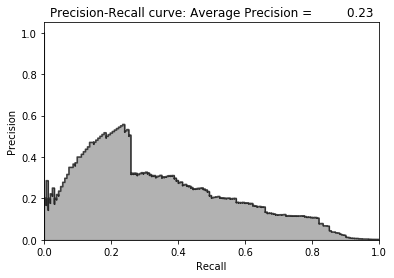

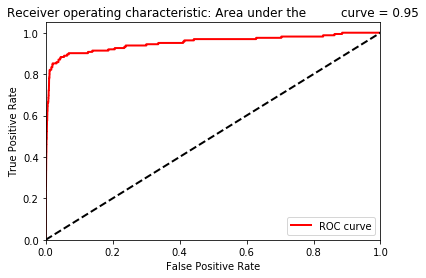

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 168us/step - loss: 0.6753 - acc: 0.5977 - val_loss: 0.5979 - val_acc: 0.7445
Epoch 2/10
190820/190820 [==============================] - 31s 161us/step - loss: 0.5900 - acc: 0.7688 - val_loss: 0.5838 - val_acc: 0.7567
Epoch 3/10
190820/190820 [==============================] - 30s 160us/step - loss: 0.5774 - acc: 0.8011 - val_loss: 0.5760 - val_acc: 0.8129
Epoch 4/10
190820/190820 [==============================] - 31s 162us/step - loss: 0.5723 - acc: 0.8157 - val_loss: 0.5674 - val_acc: 0.8367
Epoch 5/10
190820/190820 [==============================] - 32s 165us/step - loss: 0.5711 - acc: 0.8215 - val_loss: 0.5738 - val_acc: 0.7867
Epoch 6/10
190820/190820 [==============================] - 31s 161us/step - loss: 0.5715 - acc: 0.8206 - val_loss: 0.5673 - val_acc: 0.8293
Epoch 7/10
190820/190820 [==============================] - 30s 159us/step - loss: 0.5692 - acc: 0.826

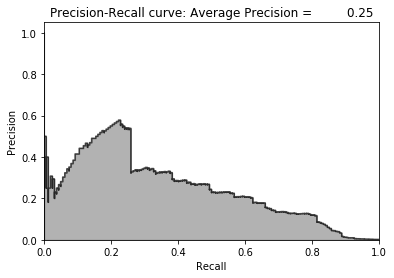

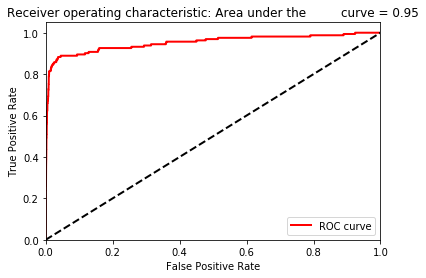

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 163us/step - loss: 0.6879 - acc: 0.6280 - val_loss: 0.6279 - val_acc: 0.7482
Epoch 2/10
190820/190820 [==============================] - 30s 159us/step - loss: 0.6120 - acc: 0.7796 - val_loss: 0.6011 - val_acc: 0.8104
Epoch 3/10
190820/190820 [==============================] - 31s 161us/step - loss: 0.5991 - acc: 0.8051 - val_loss: 0.5948 - val_acc: 0.8241
Epoch 4/10
190820/190820 [==============================] - 30s 160us/step - loss: 0.6022 - acc: 0.7991 - val_loss: 0.6123 - val_acc: 0.7645
Epoch 5/10
190820/190820 [==============================] - 31s 163us/step - loss: 0.6032 - acc: 0.8075 - val_loss: 0.5940 - val_acc: 0.8307
Epoch 6/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.5971 - acc: 0.8143 - val_loss: 0.5918 - val_acc: 0.8220
Epoch 7/10
190820/190820 [==============================] - 31s 163us/step - loss: 0.5974 - acc: 0.818

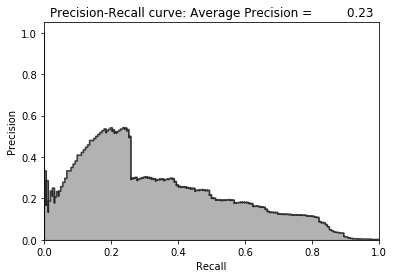

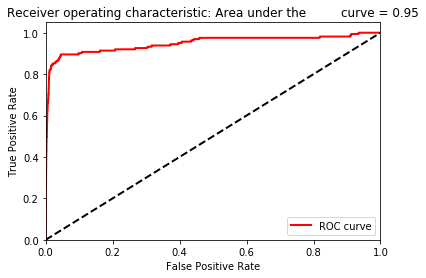

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 33s 171us/step - loss: 0.7062 - acc: 0.5602 - val_loss: 0.6427 - val_acc: 0.7175
Epoch 2/10
190820/190820 [==============================] - 31s 164us/step - loss: 0.6336 - acc: 0.7295 - val_loss: 0.6280 - val_acc: 0.7496
Epoch 3/10
190820/190820 [==============================] - 32s 165us/step - loss: 0.6269 - acc: 0.7461 - val_loss: 0.6234 - val_acc: 0.7524
Epoch 4/10
190820/190820 [==============================] - 31s 164us/step - loss: 0.6088 - acc: 0.7848 - val_loss: 0.6053 - val_acc: 0.8029
Epoch 5/10
190820/190820 [==============================] - 31s 160us/step - loss: 0.6061 - acc: 0.7933 - val_loss: 0.6082 - val_acc: 0.7599
Epoch 6/10
190820/190820 [==============================] - 31s 160us/step - loss: 0.6055 - acc: 0.7954 - val_loss: 0.6051 - val_acc: 0.7959
Epoch 7/10
190820/190820 [==============================] - 31s 160us/step - loss: 0.6051 - acc: 0.797

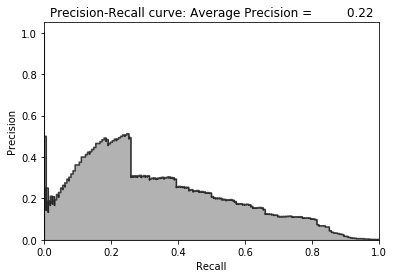

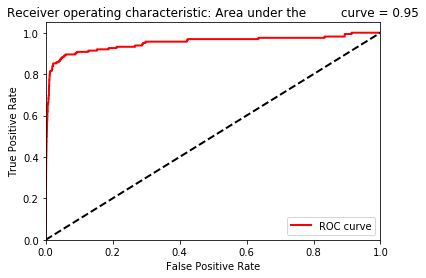

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 169us/step - loss: 0.6574 - acc: 0.6386 - val_loss: 0.5834 - val_acc: 0.7924
Epoch 2/10
190820/190820 [==============================] - 32s 169us/step - loss: 0.5764 - acc: 0.8042 - val_loss: 0.5694 - val_acc: 0.8168
Epoch 3/10
190820/190820 [==============================] - 33s 171us/step - loss: 0.5633 - acc: 0.8335 - val_loss: 0.5540 - val_acc: 0.8674
Epoch 4/10
190820/190820 [==============================] - 32s 166us/step - loss: 0.5533 - acc: 0.8450 - val_loss: 0.5432 - val_acc: 0.8527
Epoch 5/10
190820/190820 [==============================] - 32s 165us/step - loss: 0.5457 - acc: 0.8520 - val_loss: 0.5408 - val_acc: 0.8650
Epoch 6/10
190820/190820 [==============================] - 32s 167us/step - loss: 0.5442 - acc: 0.8552 - val_loss: 0.5445 - val_acc: 0.8441
Epoch 7/10
190820/190820 [==============================] - 32s 167us/step - loss: 0.5474 - acc: 0.853

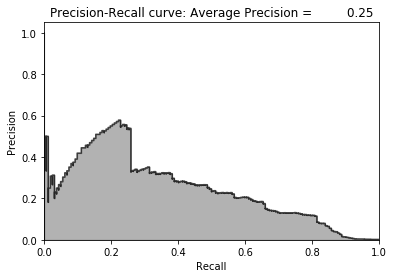

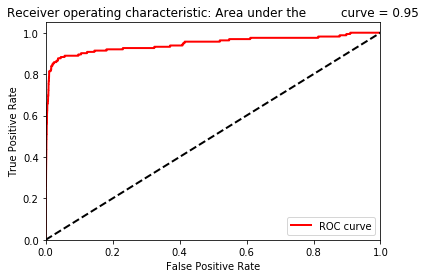

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 166us/step - loss: 0.6707 - acc: 0.6424 - val_loss: 0.6404 - val_acc: 0.7122
Epoch 2/10
190820/190820 [==============================] - 31s 162us/step - loss: 0.6224 - acc: 0.7822 - val_loss: 0.6117 - val_acc: 0.8043
Epoch 3/10
190820/190820 [==============================] - 31s 163us/step - loss: 0.6013 - acc: 0.8144 - val_loss: 0.5886 - val_acc: 0.8475
Epoch 4/10
190820/190820 [==============================] - 31s 163us/step - loss: 0.5943 - acc: 0.8323 - val_loss: 0.5934 - val_acc: 0.8297
Epoch 5/10
190820/190820 [==============================] - 32s 167us/step - loss: 0.5900 - acc: 0.8392 - val_loss: 0.5848 - val_acc: 0.8625
Epoch 6/10
190820/190820 [==============================] - 33s 171us/step - loss: 0.5870 - acc: 0.8081 - val_loss: 0.5749 - val_acc: 0.8088
Epoch 7/10
190820/190820 [==============================] - 32s 168us/step - loss: 0.5768 - acc: 0.825

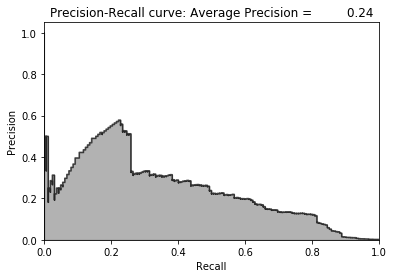

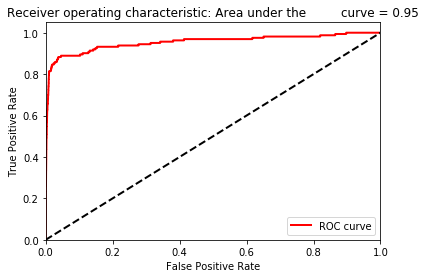

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 34s 178us/step - loss: 0.6770 - acc: 0.6134 - val_loss: 0.6119 - val_acc: 0.7434
Epoch 2/10
190820/190820 [==============================] - 33s 173us/step - loss: 0.5940 - acc: 0.7834 - val_loss: 0.5914 - val_acc: 0.8085
Epoch 3/10
190820/190820 [==============================] - 33s 174us/step - loss: 0.5855 - acc: 0.8081 - val_loss: 0.5853 - val_acc: 0.7930
Epoch 4/10
190820/190820 [==============================] - 32s 170us/step - loss: 0.5855 - acc: 0.8118 - val_loss: 0.5808 - val_acc: 0.8283
Epoch 5/10
190820/190820 [==============================] - 33s 170us/step - loss: 0.5832 - acc: 0.8161 - val_loss: 0.5808 - val_acc: 0.8233
Epoch 6/10
190820/190820 [==============================] - 32s 167us/step - loss: 0.5819 - acc: 0.8199 - val_loss: 0.5802 - val_acc: 0.8283
Epoch 7/10
190820/190820 [==============================] - 33s 171us/step - loss: 0.5814 - acc: 0.821

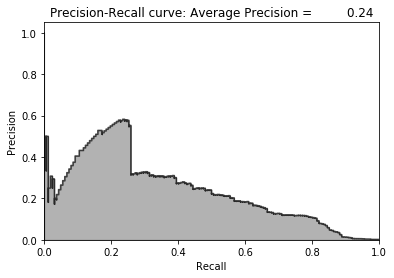

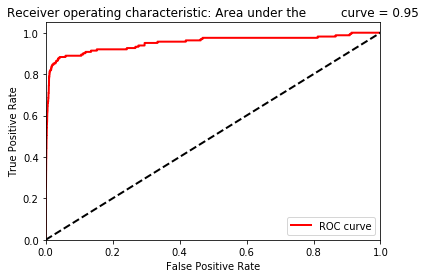

Mean average precision over 10 runs:  0.23145337591038948


[0.22844607905495204,
 0.22790014970073896,
 0.2082714667223804,
 0.22814962996729932,
 0.24775474069244272,
 0.2279213084163665,
 0.21782962431197758,
 0.2465497864166432,
 0.2422849929178301,
 0.23942598090326406]

In [15]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply ReLu throughout
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 22 nodes
    model.add(Dense(units=27, activation='relu',input_dim=29))
    model.add(Dense(units=22, activation='relu'))

    # Apply ReLu throughout
    # Generate third hidden layer with 27 nodes
    # Generate output layer with 29 nodes
    model.add(Dense(units=27, activation='relu'))
    model.add(Dense(units=29, activation='relu'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [16]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.23145337591038948
Coefficient of variation over 10 runs:  0.05189289018090329


[0.22844607905495204,
 0.22790014970073896,
 0.2082714667223804,
 0.22814962996729932,
 0.24775474069244272,
 0.2279213084163665,
 0.21782962431197758,
 0.2465497864166432,
 0.2422849929178301,
 0.23942598090326406]

In [ ]:
# Model five
# Two layer overcomplete autoencoder with linear activation
# 29 -> 40 -> 29

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 161us/step - loss: 0.0498 - acc: 0.9438 - val_loss: 9.2301e-06 - val_acc: 0.9982
Epoch 2/10
190820/190820 [==============================] - 33s 171us/step - loss: 0.0014 - acc: 0.9925 - val_loss: 0.0019 - val_acc: 0.9909
Epoch 3/10
190820/190820 [==============================] - 33s 172us/step - loss: 7.6469e-04 - acc: 0.9947 - val_loss: 4.5314e-05 - val_acc: 0.9970
Epoch 4/10
190820/190820 [==============================] - 35s 182us/step - loss: 0.0010 - acc: 0.9930 - val_loss: 0.0039 - val_acc: 0.9859
Epoch 5/10
190820/190820 [==============================] - 32s 166us/step - loss: 0.0012 - acc: 0.9924 - val_loss: 8.5141e-04 - val_acc: 0.9886
Epoch 6/10
190820/190820 [==============================] - 31s 163us/step - loss: 5.0655e-04 - acc: 0.9955 - val_loss: 8.2359e-04 - val_acc: 0.9910
Epoch 7/10
190820/190820 [==============================] - 30s 156us/step - l

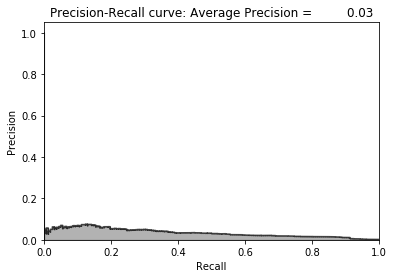

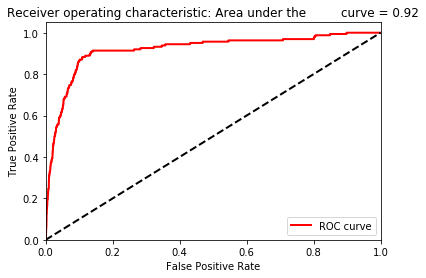

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 170us/step - loss: 0.0460 - acc: 0.9399 - val_loss: 5.5970e-06 - val_acc: 0.9990
Epoch 2/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.0010 - acc: 0.9926 - val_loss: 9.3073e-05 - val_acc: 0.9968
Epoch 3/10
190820/190820 [==============================] - 30s 159us/step - loss: 7.6726e-04 - acc: 0.9924 - val_loss: 3.9078e-06 - val_acc: 0.9989
Epoch 4/10
190820/190820 [==============================] - 29s 155us/step - loss: 8.4935e-04 - acc: 0.9922 - val_loss: 5.2274e-05 - val_acc: 0.9970
Epoch 5/10
190820/190820 [==============================] - 30s 157us/step - loss: 6.5315e-04 - acc: 0.9948 - val_loss: 5.2871e-05 - val_acc: 0.9977
Epoch 6/10
190820/190820 [==============================] - 30s 156us/step - loss: 7.3383e-04 - acc: 0.9945 - val_loss: 1.0479e-05 - val_acc: 0.9983
Epoch 7/10
190820/190820 [==============================] - 30

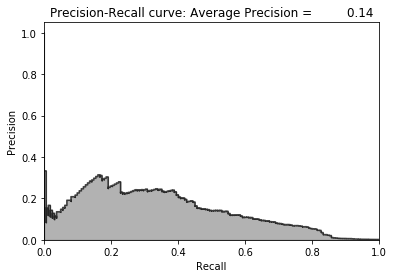

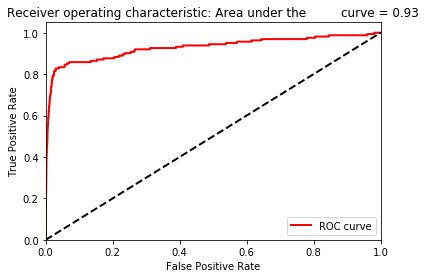

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 168us/step - loss: 0.0516 - acc: 0.9346 - val_loss: 1.5333e-04 - val_acc: 0.9953
Epoch 2/10
190820/190820 [==============================] - 29s 154us/step - loss: 9.9907e-04 - acc: 0.9924 - val_loss: 0.0038 - val_acc: 0.9686
Epoch 3/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.0011 - acc: 0.9937 - val_loss: 5.1236e-04 - val_acc: 0.9905
Epoch 4/10
190820/190820 [==============================] - 29s 154us/step - loss: 8.6410e-04 - acc: 0.9940 - val_loss: 0.0201 - val_acc: 0.9542
Epoch 5/10
190820/190820 [==============================] - 29s 154us/step - loss: 5.1979e-04 - acc: 0.9944 - val_loss: 2.7268e-09 - val_acc: 1.0000
Epoch 6/10
190820/190820 [==============================] - 30s 159us/step - loss: 7.1006e-04 - acc: 0.9930 - val_loss: 2.2153e-05 - val_acc: 0.9971
Epoch 7/10
190820/190820 [==============================] - 31s 161us/

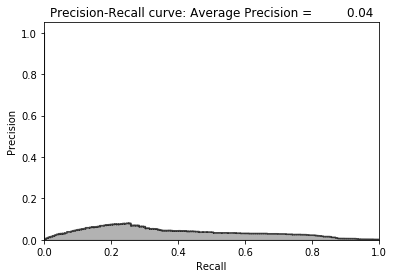

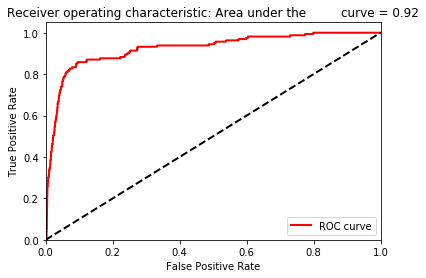

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 164us/step - loss: 0.0710 - acc: 0.9067 - val_loss: 3.0829e-04 - val_acc: 0.9928
Epoch 2/10
190820/190820 [==============================] - 29s 155us/step - loss: 0.0012 - acc: 0.9922 - val_loss: 1.6485e-04 - val_acc: 0.9960
Epoch 3/10
190820/190820 [==============================] - 29s 154us/step - loss: 9.6612e-04 - acc: 0.9921 - val_loss: 1.7852e-06 - val_acc: 0.9994
Epoch 4/10
190820/190820 [==============================] - 29s 154us/step - loss: 7.1621e-04 - acc: 0.9927 - val_loss: 2.6104e-05 - val_acc: 0.9972
Epoch 5/10
190820/190820 [==============================] - 30s 156us/step - loss: 7.1875e-04 - acc: 0.9927 - val_loss: 4.4316e-04 - val_acc: 0.9888
Epoch 6/10
190820/190820 [==============================] - 30s 156us/step - loss: 8.1174e-04 - acc: 0.9933 - val_loss: 1.2673e-06 - val_acc: 0.9996
Epoch 7/10
190820/190820 [==============================] - 29

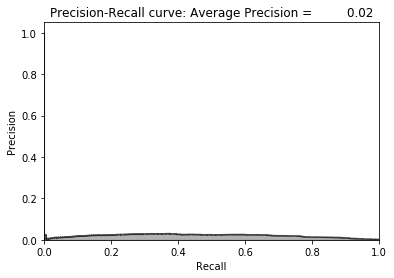

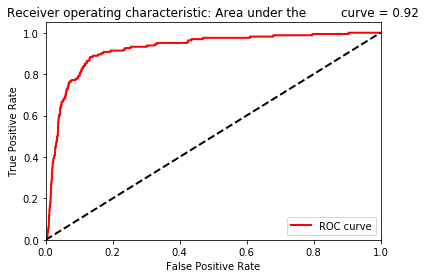

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 165us/step - loss: 0.0403 - acc: 0.9457 - val_loss: 1.3388e-05 - val_acc: 0.9982
Epoch 2/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.0013 - acc: 0.9920 - val_loss: 1.1702e-05 - val_acc: 0.9990
Epoch 3/10
190820/190820 [==============================] - 30s 156us/step - loss: 9.6235e-04 - acc: 0.9938 - val_loss: 3.6207e-04 - val_acc: 0.9908
Epoch 4/10
190820/190820 [==============================] - 30s 157us/step - loss: 0.0010 - acc: 0.9931 - val_loss: 1.6162e-05 - val_acc: 0.9989
Epoch 5/10
190820/190820 [==============================] - 30s 155us/step - loss: 6.7711e-04 - acc: 0.9942 - val_loss: 1.1799e-05 - val_acc: 0.9988
Epoch 6/10
190820/190820 [==============================] - 30s 156us/step - loss: 7.8168e-04 - acc: 0.9931 - val_loss: 4.0705e-05 - val_acc: 0.9966
Epoch 7/10
190820/190820 [==============================] - 30s 15

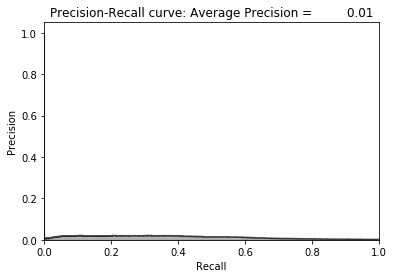

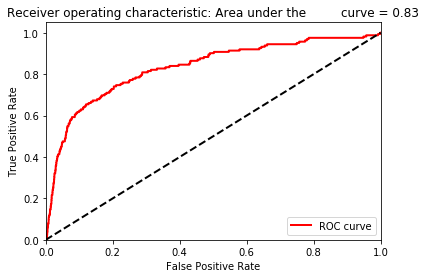

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 167us/step - loss: 0.1315 - acc: 0.8494 - val_loss: 0.0024 - val_acc: 0.9848
Epoch 2/10
190820/190820 [==============================] - 36s 188us/step - loss: 0.0011 - acc: 0.9924 - val_loss: 2.6392e-06 - val_acc: 0.9993
Epoch 3/10
190820/190820 [==============================] - 34s 181us/step - loss: 0.0011 - acc: 0.9926 - val_loss: 8.8760e-05 - val_acc: 0.9964
Epoch 4/10
190820/190820 [==============================] - 31s 163us/step - loss: 7.3347e-04 - acc: 0.9953 - val_loss: 0.0102 - val_acc: 0.9774
Epoch 5/10
190820/190820 [==============================] - 32s 166us/step - loss: 0.0011 - acc: 0.9937 - val_loss: 8.0922e-08 - val_acc: 0.9999
Epoch 6/10
190820/190820 [==============================] - 32s 165us/step - loss: 8.0794e-04 - acc: 0.9933 - val_loss: 1.0804e-06 - val_acc: 0.9996
Epoch 7/10
190820/190820 [==============================] - 31s 162us/step - l

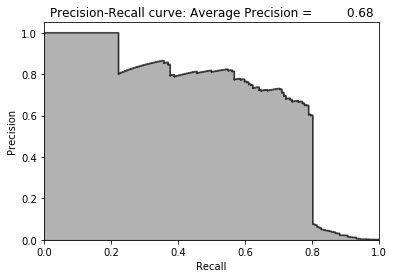

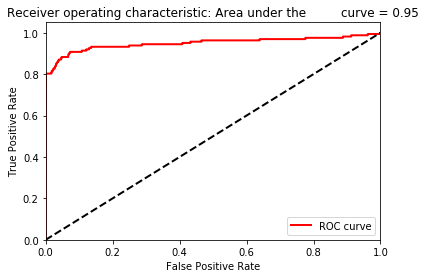

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 33s 172us/step - loss: 0.0494 - acc: 0.9354 - val_loss: 6.8600e-05 - val_acc: 0.9970
Epoch 2/10
190820/190820 [==============================] - 31s 165us/step - loss: 7.9845e-04 - acc: 0.9934 - val_loss: 1.2232e-04 - val_acc: 0.9941
Epoch 3/10
190820/190820 [==============================] - 32s 166us/step - loss: 7.3221e-04 - acc: 0.9928 - val_loss: 0.0024 - val_acc: 0.9662
Epoch 4/10
190820/190820 [==============================] - 32s 170us/step - loss: 7.0594e-04 - acc: 0.9929 - val_loss: 3.8577e-05 - val_acc: 0.9966
Epoch 5/10
190820/190820 [==============================] - 33s 172us/step - loss: 8.9961e-04 - acc: 0.9922 - val_loss: 0.0089 - val_acc: 0.9548
Epoch 6/10
190820/190820 [==============================] - 32s 169us/step - loss: 6.9745e-04 - acc: 0.9940 - val_loss: 0.0012 - val_acc: 0.9972
Epoch 7/10
190820/190820 [==============================] - 30s 157us/

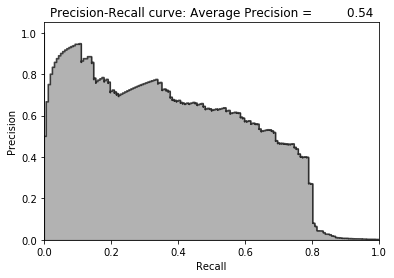

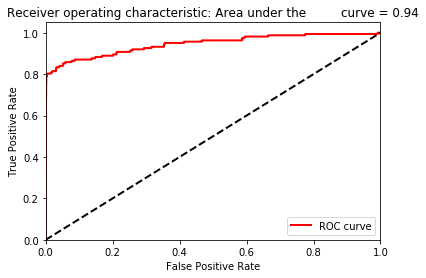

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 168us/step - loss: 0.0495 - acc: 0.9359 - val_loss: 4.2103e-05 - val_acc: 0.9980
Epoch 2/10
190820/190820 [==============================] - 30s 158us/step - loss: 8.9653e-04 - acc: 0.9946 - val_loss: 1.1334e-07 - val_acc: 0.9998
Epoch 3/10
190820/190820 [==============================] - 30s 159us/step - loss: 7.8517e-04 - acc: 0.9936 - val_loss: 6.3701e-07 - val_acc: 0.9998
Epoch 4/10
190820/190820 [==============================] - 30s 158us/step - loss: 6.7065e-04 - acc: 0.9932 - val_loss: 5.9645e-05 - val_acc: 0.9966
Epoch 5/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.0013 - acc: 0.9928 - val_loss: 3.0422e-06 - val_acc: 0.9993
Epoch 6/10
190820/190820 [==============================] - 30s 157us/step - loss: 4.0911e-04 - acc: 0.9956 - val_loss: 3.3513e-05 - val_acc: 0.9974
Epoch 7/10
190820/190820 [==============================] - 30

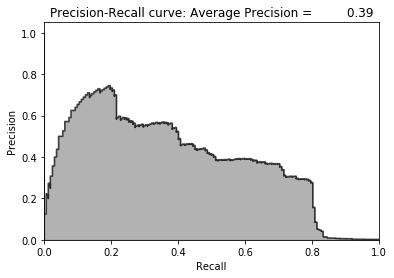

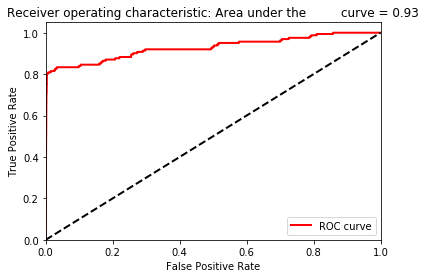

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 168us/step - loss: 0.0788 - acc: 0.9172 - val_loss: 0.0033 - val_acc: 0.9723
Epoch 2/10
190820/190820 [==============================] - 30s 159us/step - loss: 8.5272e-04 - acc: 0.9931 - val_loss: 1.4513e-05 - val_acc: 0.9986
Epoch 3/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.0010 - acc: 0.9911 - val_loss: 0.0012 - val_acc: 0.9924
Epoch 4/10
190820/190820 [==============================] - 31s 160us/step - loss: 8.4244e-04 - acc: 0.9927 - val_loss: 1.7589e-06 - val_acc: 0.9993
Epoch 5/10
190820/190820 [==============================] - 31s 160us/step - loss: 0.0010 - acc: 0.9930 - val_loss: 3.1913e-04 - val_acc: 0.9904
Epoch 6/10
190820/190820 [==============================] - 30s 158us/step - loss: 8.3688e-04 - acc: 0.9940 - val_loss: 0.0044 - val_acc: 0.9857
Epoch 7/10
190820/190820 [==============================] - 30s 158us/step - l

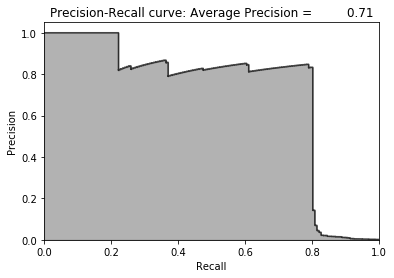

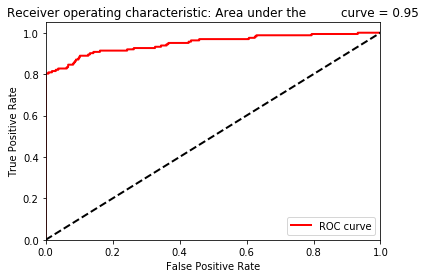

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 170us/step - loss: 0.0633 - acc: 0.9273 - val_loss: 5.0856e-04 - val_acc: 0.9953
Epoch 2/10
190820/190820 [==============================] - 30s 160us/step - loss: 0.0010 - acc: 0.9915 - val_loss: 2.8645e-04 - val_acc: 0.9924
Epoch 3/10
190820/190820 [==============================] - 31s 162us/step - loss: 7.2256e-04 - acc: 0.9932 - val_loss: 5.0217e-06 - val_acc: 0.9993
Epoch 4/10
190820/190820 [==============================] - 30s 159us/step - loss: 7.7488e-04 - acc: 0.9935 - val_loss: 2.1962e-06 - val_acc: 0.9992
Epoch 5/10
190820/190820 [==============================] - 30s 159us/step - loss: 9.8470e-04 - acc: 0.9933 - val_loss: 3.5848e-05 - val_acc: 0.9976
Epoch 6/10
190820/190820 [==============================] - 30s 160us/step - loss: 5.1709e-04 - acc: 0.9944 - val_loss: 4.8154e-08 - val_acc: 0.9999
Epoch 7/10
190820/190820 [==============================] - 31

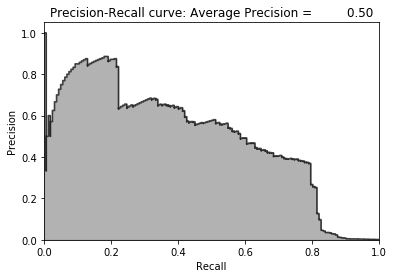

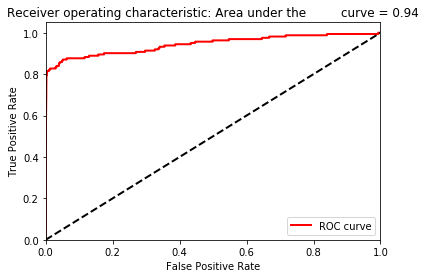

Mean average precision over 10 runs:  0.3061984081568074


[0.03394897465567298,
 0.14322827274920255,
 0.03610123178524601,
 0.019735235731640446,
 0.012571999125881042,
 0.6788921569665146,
 0.5411349583727725,
 0.388474572258503,
 0.7089617645810736,
 0.4989349153415674]

In [58]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function throughout
    # Generate first hidden layer with 40 nodes
    model.add(Dense(units=40, activation='linear',input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [59]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.3061984081568074
Coefficient of variation over 10 runs:  0.8896926168864564


[0.03394897465567298,
 0.14322827274920255,
 0.03610123178524601,
 0.019735235731640446,
 0.012571999125881042,
 0.6788921569665146,
 0.5411349583727725,
 0.388474572258503,
 0.7089617645810736,
 0.4989349153415674]

In [ ]:
# Model six
# Two layer overcomplete autoencoder with linear activation and dropout
# 29 -> 40 -> 29
# Dropout percentage: 10%

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.1358 - acc: 0.7430 - val_loss: 0.0082 - val_acc: 0.9742
Epoch 2/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.0782 - acc: 0.7849 - val_loss: 0.0094 - val_acc: 0.9689
Epoch 3/10
190820/190820 [==============================] - 28s 149us/step - loss: 0.0753 - acc: 0.7858 - val_loss: 0.0102 - val_acc: 0.9672
Epoch 4/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.0772 - acc: 0.7864 - val_loss: 0.0093 - val_acc: 0.9677
Epoch 5/10
190820/190820 [==============================] - 28s 147us/step - loss: 0.0813 - acc: 0.7843 - val_loss: 0.0108 - val_acc: 0.9631
Epoch 6/10
190820/190820 [==============================] - 28s 149us/step - loss: 0.0756 - acc: 0.7844 - val_loss: 0.0095 - val_acc: 0.9654
Epoch 7/10
190820/190820 [==============================] - 29s 150us/step - loss: 0.0743 - acc: 0.785

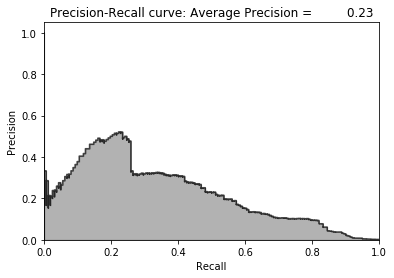

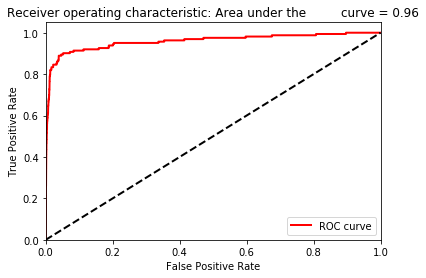

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 29s 153us/step - loss: 0.1477 - acc: 0.7358 - val_loss: 0.0092 - val_acc: 0.9672
Epoch 2/10
190820/190820 [==============================] - 28s 147us/step - loss: 0.0776 - acc: 0.7862 - val_loss: 0.0088 - val_acc: 0.9681
Epoch 3/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.0792 - acc: 0.7844 - val_loss: 0.0081 - val_acc: 0.9717
Epoch 4/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.0780 - acc: 0.7872 - val_loss: 0.0080 - val_acc: 0.9780
Epoch 5/10
190820/190820 [==============================] - 28s 147us/step - loss: 0.0770 - acc: 0.7854 - val_loss: 0.0123 - val_acc: 0.9573
Epoch 6/10
190820/190820 [==============================] - 28s 147us/step - loss: 0.0766 - acc: 0.7884 - val_loss: 0.0079 - val_acc: 0.9746
Epoch 7/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.0778 - acc: 0.785

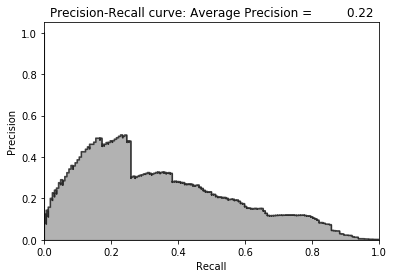

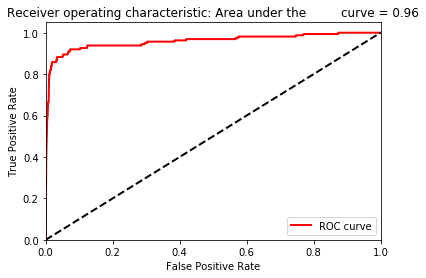

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 29s 153us/step - loss: 0.1480 - acc: 0.7328 - val_loss: 0.0111 - val_acc: 0.9644
Epoch 2/10
190820/190820 [==============================] - 28s 149us/step - loss: 0.0765 - acc: 0.7860 - val_loss: 0.0111 - val_acc: 0.9618
Epoch 3/10
190820/190820 [==============================] - 29s 150us/step - loss: 0.0757 - acc: 0.7858 - val_loss: 0.0069 - val_acc: 0.9738
Epoch 4/10
190820/190820 [==============================] - 29s 151us/step - loss: 0.0756 - acc: 0.7860 - val_loss: 0.0178 - val_acc: 0.9467
Epoch 5/10
190820/190820 [==============================] - 28s 147us/step - loss: 0.0763 - acc: 0.7840 - val_loss: 0.0083 - val_acc: 0.9714
Epoch 6/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.0775 - acc: 0.7837 - val_loss: 0.0074 - val_acc: 0.9747
Epoch 7/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.0755 - acc: 0.786

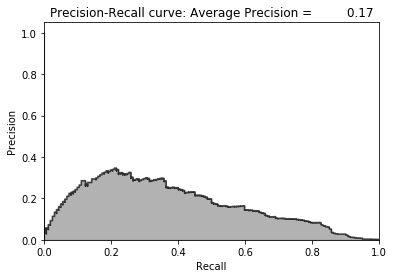

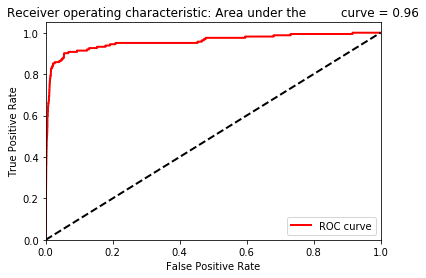

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.1661 - acc: 0.7262 - val_loss: 0.0101 - val_acc: 0.9683
Epoch 2/10
190820/190820 [==============================] - 29s 150us/step - loss: 0.0771 - acc: 0.7869 - val_loss: 0.0077 - val_acc: 0.9741
Epoch 3/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.0759 - acc: 0.7864 - val_loss: 0.0088 - val_acc: 0.9678
Epoch 4/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0784 - acc: 0.7865 - val_loss: 0.0088 - val_acc: 0.9687
Epoch 5/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.0763 - acc: 0.7850 - val_loss: 0.0080 - val_acc: 0.9749
Epoch 6/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.0768 - acc: 0.7865 - val_loss: 0.0081 - val_acc: 0.9749
Epoch 7/10
190820/190820 [==============================] - 28s 144us/step - loss: 0.0774 - acc: 0.786

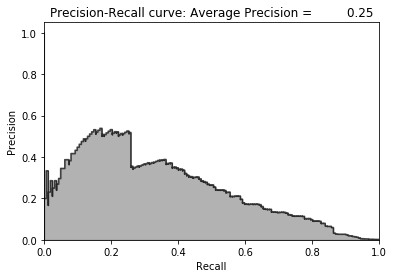

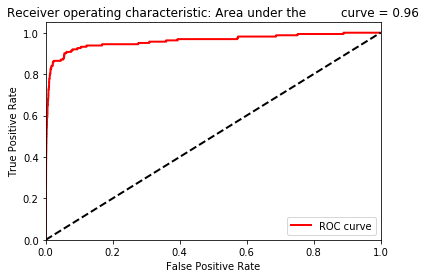

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1481 - acc: 0.7324 - val_loss: 0.0083 - val_acc: 0.9693
Epoch 2/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0777 - acc: 0.7880 - val_loss: 0.0074 - val_acc: 0.9781
Epoch 3/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0771 - acc: 0.7869 - val_loss: 0.0086 - val_acc: 0.9727
Epoch 4/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0772 - acc: 0.7876 - val_loss: 0.0105 - val_acc: 0.9662
Epoch 5/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.0763 - acc: 0.7879 - val_loss: 0.0076 - val_acc: 0.9760
Epoch 6/10
190820/190820 [==============================] - 27s 144us/step - loss: 0.0765 - acc: 0.7880 - val_loss: 0.0092 - val_acc: 0.9708
Epoch 7/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0765 - acc: 0.788

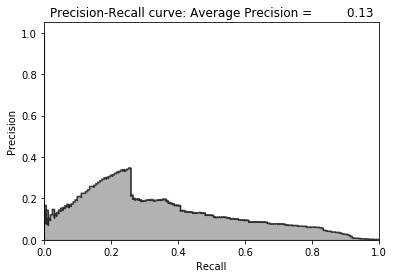

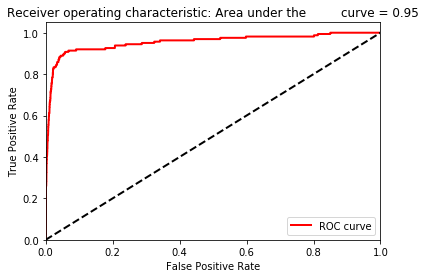

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 24s 124us/step - loss: 0.1409 - acc: 0.7377 - val_loss: 0.0089 - val_acc: 0.9729
Epoch 2/10
190820/190820 [==============================] - 23s 120us/step - loss: 0.0775 - acc: 0.7856 - val_loss: 0.0076 - val_acc: 0.9723
Epoch 3/10
190820/190820 [==============================] - 23s 120us/step - loss: 0.0778 - acc: 0.7886 - val_loss: 0.0128 - val_acc: 0.9628
Epoch 4/10
190820/190820 [==============================] - 23s 119us/step - loss: 0.0780 - acc: 0.7851 - val_loss: 0.0075 - val_acc: 0.9735
Epoch 5/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0768 - acc: 0.7865 - val_loss: 0.0074 - val_acc: 0.9763
Epoch 6/10
190820/190820 [==============================] - 28s 149us/step - loss: 0.0763 - acc: 0.7873 - val_loss: 0.0069 - val_acc: 0.9772
Epoch 7/10
190820/190820 [==============================] - 29s 152us/step - loss: 0.0775 - acc: 0.786

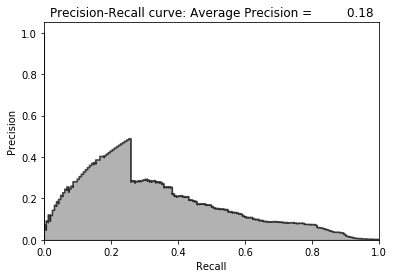

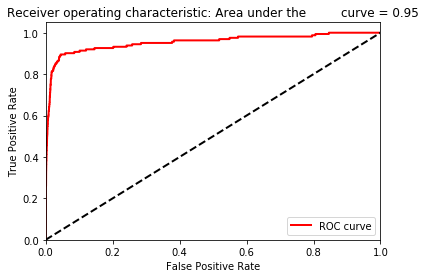

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 149us/step - loss: 0.1579 - acc: 0.7267 - val_loss: 0.0078 - val_acc: 0.9740
Epoch 2/10
190820/190820 [==============================] - 28s 144us/step - loss: 0.0765 - acc: 0.7838 - val_loss: 0.0089 - val_acc: 0.9703
Epoch 3/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.0772 - acc: 0.7843 - val_loss: 0.0073 - val_acc: 0.9747
Epoch 4/10
190820/190820 [==============================] - 28s 144us/step - loss: 0.0776 - acc: 0.7832 - val_loss: 0.0100 - val_acc: 0.9688
Epoch 5/10
190820/190820 [==============================] - 28s 144us/step - loss: 0.0772 - acc: 0.7872 - val_loss: 0.0164 - val_acc: 0.9609
Epoch 6/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.0766 - acc: 0.7851 - val_loss: 0.0072 - val_acc: 0.9777
Epoch 7/10
190820/190820 [==============================] - 29s 150us/step - loss: 0.0757 - acc: 0.785

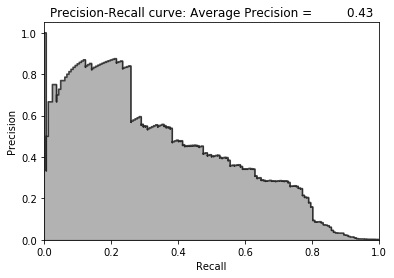

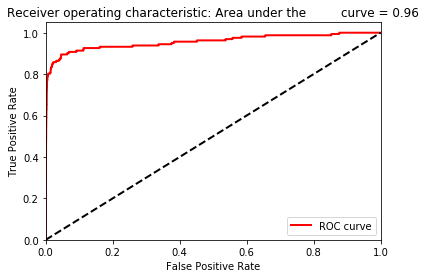

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 29s 151us/step - loss: 0.1376 - acc: 0.7377 - val_loss: 0.0078 - val_acc: 0.9747
Epoch 2/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.0778 - acc: 0.7837 - val_loss: 0.0118 - val_acc: 0.9634
Epoch 3/10
190820/190820 [==============================] - 29s 151us/step - loss: 0.0783 - acc: 0.7872 - val_loss: 0.0149 - val_acc: 0.9611
Epoch 4/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0768 - acc: 0.7860 - val_loss: 0.0068 - val_acc: 0.9761
Epoch 5/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0775 - acc: 0.7852 - val_loss: 0.0154 - val_acc: 0.9529
Epoch 6/10
190820/190820 [==============================] - 29s 152us/step - loss: 0.0778 - acc: 0.7856 - val_loss: 0.0065 - val_acc: 0.9792
Epoch 7/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.0754 - acc: 0.788

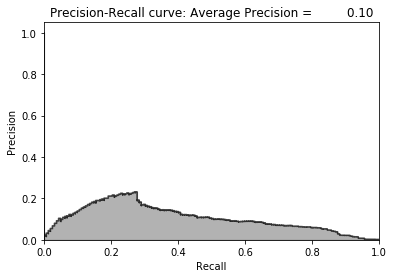

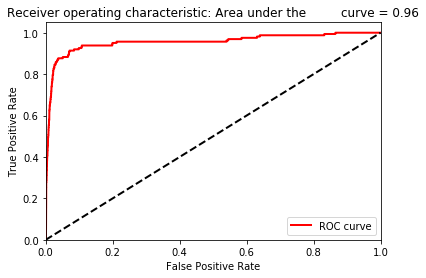

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1324 - acc: 0.7441 - val_loss: 0.0076 - val_acc: 0.9728
Epoch 2/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.0774 - acc: 0.7871 - val_loss: 0.0080 - val_acc: 0.9749
Epoch 3/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.0773 - acc: 0.7881 - val_loss: 0.0113 - val_acc: 0.9648
Epoch 4/10
190820/190820 [==============================] - 29s 152us/step - loss: 0.0765 - acc: 0.7864 - val_loss: 0.0075 - val_acc: 0.9722
Epoch 5/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.0760 - acc: 0.7880 - val_loss: 0.0069 - val_acc: 0.9775
Epoch 6/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0769 - acc: 0.7851 - val_loss: 0.0083 - val_acc: 0.9696
Epoch 7/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.0780 - acc: 0.784

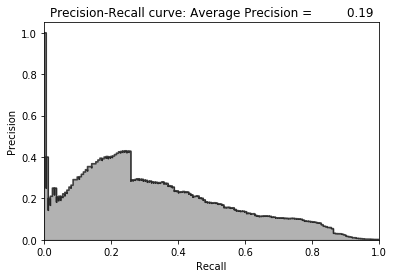

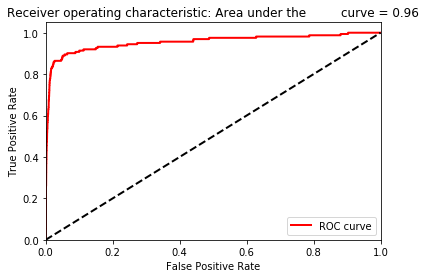

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1302 - acc: 0.7434 - val_loss: 0.0074 - val_acc: 0.9761
Epoch 2/10
190820/190820 [==============================] - 38s 201us/step - loss: 0.0759 - acc: 0.7825 - val_loss: 0.0093 - val_acc: 0.9718
Epoch 3/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.0756 - acc: 0.7843 - val_loss: 0.0123 - val_acc: 0.9594
Epoch 4/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.0767 - acc: 0.7840 - val_loss: 0.0085 - val_acc: 0.9772
Epoch 5/10
190820/190820 [==============================] - 39s 203us/step - loss: 0.0801 - acc: 0.7849 - val_loss: 0.0081 - val_acc: 0.9736
Epoch 6/10
190820/190820 [==============================] - 29s 152us/step - loss: 0.0746 - acc: 0.7851 - val_loss: 0.0071 - val_acc: 0.9765
Epoch 7/10
190820/190820 [==============================] - 29s 151us/step - loss: 0.0789 - acc: 0.785

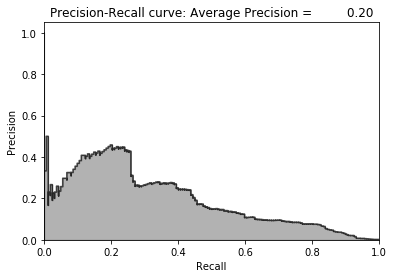

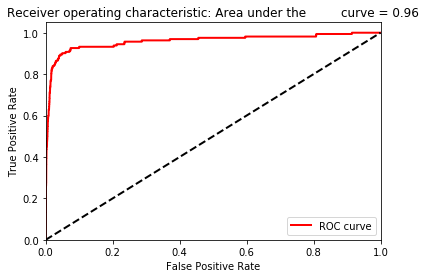

Mean average precision over 10 runs:  0.21150451381770646


[0.22549974304927337,
 0.22451178120391296,
 0.17243952488912334,
 0.2533716906936315,
 0.13251890273915556,
 0.1775116247503748,
 0.4343283958332979,
 0.10469065867732033,
 0.19480068075466764,
 0.19537213558630712]

In [17]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',input_dim=29))
    model.add(Dropout(0.10))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [18]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.21150451381770646
Coefficient of variation over 10 runs:  0.40295807771579256


[0.22549974304927337,
 0.22451178120391296,
 0.17243952488912334,
 0.2533716906936315,
 0.13251890273915556,
 0.1775116247503748,
 0.4343283958332979,
 0.10469065867732033,
 0.19480068075466764,
 0.19537213558630712]

In [19]:
# Model seven
# Two layer sparse overcomplete autoencoder with linear activation
# 29 -> 40 -> 29

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.0985 - acc: 0.9380 - val_loss: 0.0369 - val_acc: 0.9871
Epoch 2/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.0284 - acc: 0.9829 - val_loss: 0.0261 - val_acc: 0.9698
Epoch 3/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.0229 - acc: 0.9816 - val_loss: 0.0169 - val_acc: 0.9952
Epoch 4/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.0201 - acc: 0.9821 - val_loss: 0.0147 - val_acc: 0.9943
Epoch 5/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.0183 - acc: 0.9810 - val_loss: 0.0142 - val_acc: 0.9842
Epoch 6/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.0206 - acc: 0.9774 - val_loss: 0.0158 - val_acc: 0.9906
Epoch 7/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.0169 - acc: 0.981

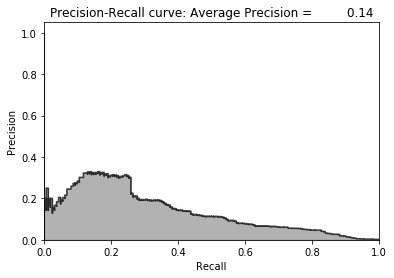

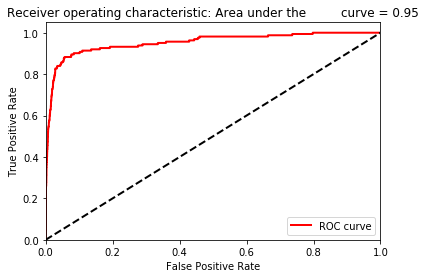

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.1205 - acc: 0.9244 - val_loss: 0.0376 - val_acc: 0.9852
Epoch 2/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.0307 - acc: 0.9856 - val_loss: 0.0230 - val_acc: 0.9815
Epoch 3/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0240 - acc: 0.9842 - val_loss: 0.0178 - val_acc: 0.9909
Epoch 4/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0211 - acc: 0.9796 - val_loss: 0.0266 - val_acc: 0.9579
Epoch 5/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0180 - acc: 0.9816 - val_loss: 0.0135 - val_acc: 0.9943
Epoch 6/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.0178 - acc: 0.9803 - val_loss: 0.0142 - val_acc: 0.9784
Epoch 7/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.0168 - acc: 0.976

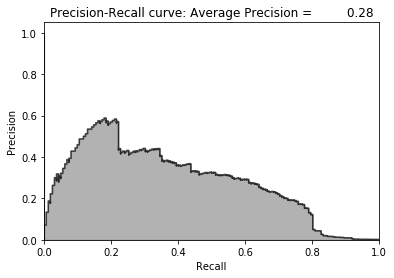

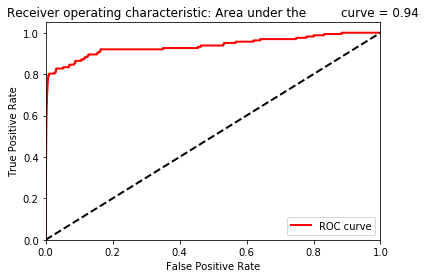

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.1028 - acc: 0.9325 - val_loss: 0.0343 - val_acc: 0.9915
Epoch 2/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0294 - acc: 0.9826 - val_loss: 0.0217 - val_acc: 0.9940
Epoch 3/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0217 - acc: 0.9822 - val_loss: 0.0176 - val_acc: 0.9885
Epoch 4/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0200 - acc: 0.9788 - val_loss: 0.0335 - val_acc: 0.8884
Epoch 5/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.0191 - acc: 0.9813 - val_loss: 0.0134 - val_acc: 0.9859
Epoch 6/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.0187 - acc: 0.9769 - val_loss: 0.0125 - val_acc: 0.9914
Epoch 7/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.0154 - acc: 0.982

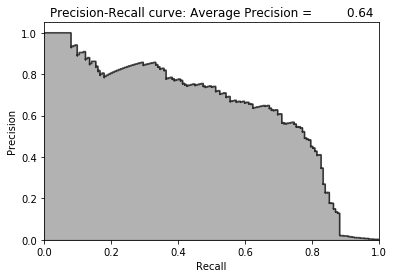

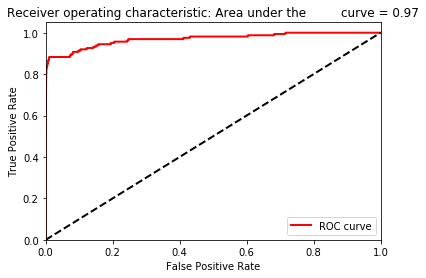

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 34s 180us/step - loss: 0.1167 - acc: 0.9284 - val_loss: 0.0365 - val_acc: 0.9909
Epoch 2/10
190820/190820 [==============================] - 33s 174us/step - loss: 0.0313 - acc: 0.9839 - val_loss: 0.0244 - val_acc: 0.9781
Epoch 3/10
190820/190820 [==============================] - 35s 182us/step - loss: 0.0228 - acc: 0.9827 - val_loss: 0.0172 - val_acc: 0.9942
Epoch 4/10
190820/190820 [==============================] - 34s 176us/step - loss: 0.0192 - acc: 0.9815 - val_loss: 0.0151 - val_acc: 0.9863
Epoch 5/10
190820/190820 [==============================] - 42s 221us/step - loss: 0.0188 - acc: 0.9809 - val_loss: 0.0133 - val_acc: 0.9913
Epoch 6/10
190820/190820 [==============================] - 32s 169us/step - loss: 0.0182 - acc: 0.9761 - val_loss: 0.0127 - val_acc: 0.9941
Epoch 7/10
190820/190820 [==============================] - 29s 149us/step - loss: 0.0177 - acc: 0.979

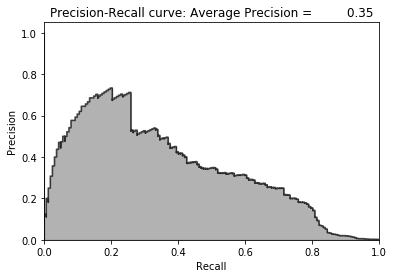

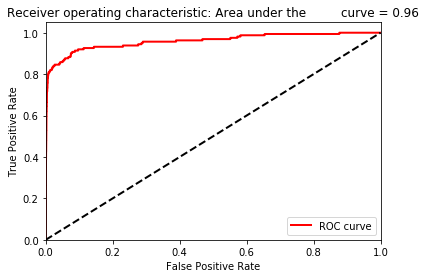

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 149us/step - loss: 0.1340 - acc: 0.9145 - val_loss: 0.0448 - val_acc: 0.9637
Epoch 2/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.0318 - acc: 0.9845 - val_loss: 0.0306 - val_acc: 0.9631
Epoch 3/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.0230 - acc: 0.9810 - val_loss: 0.0229 - val_acc: 0.9772
Epoch 4/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0205 - acc: 0.9797 - val_loss: 0.0157 - val_acc: 0.9899
Epoch 5/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0186 - acc: 0.9779 - val_loss: 0.0161 - val_acc: 0.9747
Epoch 6/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0181 - acc: 0.9786 - val_loss: 0.0127 - val_acc: 0.9911
Epoch 7/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0176 - acc: 0.976

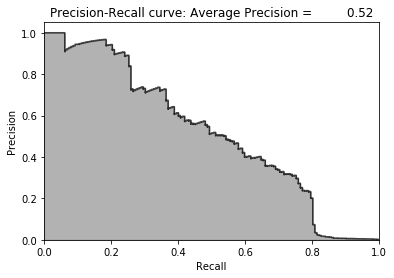

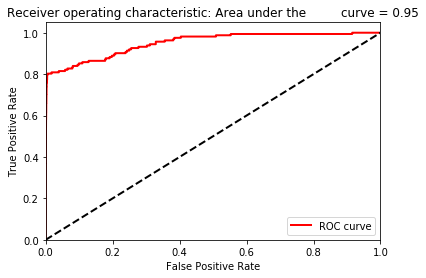

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.0987 - acc: 0.9411 - val_loss: 0.0376 - val_acc: 0.9674
Epoch 2/10
190820/190820 [==============================] - 28s 147us/step - loss: 0.0287 - acc: 0.9826 - val_loss: 0.0228 - val_acc: 0.9848
Epoch 3/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.0222 - acc: 0.9827 - val_loss: 0.0293 - val_acc: 0.9512
Epoch 4/10
190820/190820 [==============================] - 28s 144us/step - loss: 0.0210 - acc: 0.9807 - val_loss: 0.0271 - val_acc: 0.9640
Epoch 5/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.0186 - acc: 0.9786 - val_loss: 0.0164 - val_acc: 0.9809
Epoch 6/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0169 - acc: 0.9805 - val_loss: 0.0121 - val_acc: 0.9956
Epoch 7/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.0173 - acc: 0.978

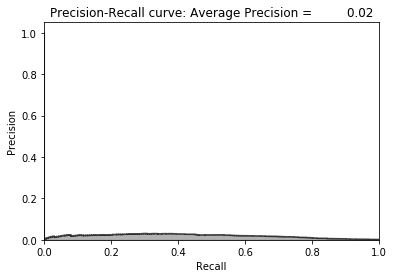

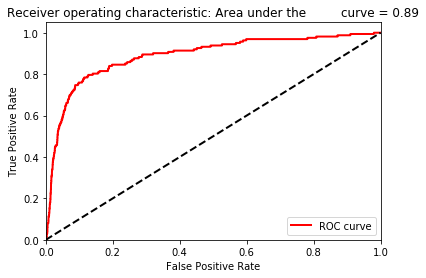

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1256 - acc: 0.9178 - val_loss: 0.0398 - val_acc: 0.9761
Epoch 2/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0302 - acc: 0.9834 - val_loss: 0.0224 - val_acc: 0.9903
Epoch 3/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0218 - acc: 0.9824 - val_loss: 0.0170 - val_acc: 0.9849
Epoch 4/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.0198 - acc: 0.9807 - val_loss: 0.0145 - val_acc: 0.9936
Epoch 5/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0207 - acc: 0.9786 - val_loss: 0.0135 - val_acc: 0.9947
Epoch 6/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0180 - acc: 0.9771 - val_loss: 0.0247 - val_acc: 0.9464
Epoch 7/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0206 - acc: 0.977

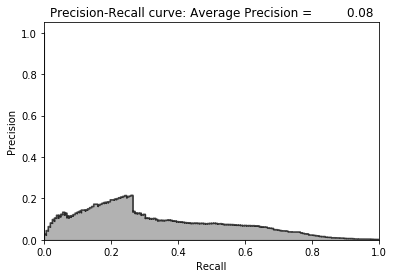

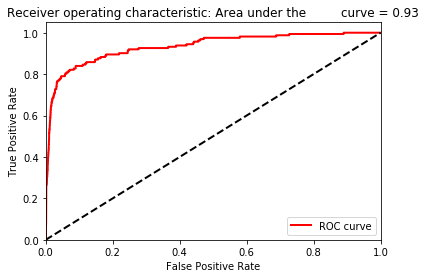

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.1216 - acc: 0.9197 - val_loss: 0.0390 - val_acc: 0.9793
Epoch 2/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0327 - acc: 0.9835 - val_loss: 0.0261 - val_acc: 0.9864
Epoch 3/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0245 - acc: 0.9829 - val_loss: 0.0341 - val_acc: 0.9558
Epoch 4/10
190820/190820 [==============================] - 23s 123us/step - loss: 0.0207 - acc: 0.9808 - val_loss: 0.0448 - val_acc: 0.9321
Epoch 5/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0186 - acc: 0.9812 - val_loss: 0.0274 - val_acc: 0.9693
Epoch 6/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0194 - acc: 0.9752 - val_loss: 0.0132 - val_acc: 0.9918
Epoch 7/10
190820/190820 [==============================] - 28s 144us/step - loss: 0.0171 - acc: 0.978

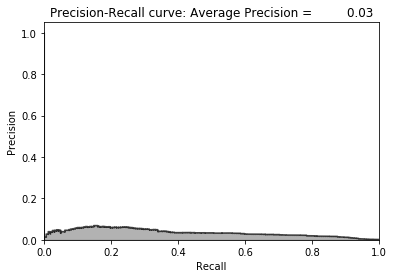

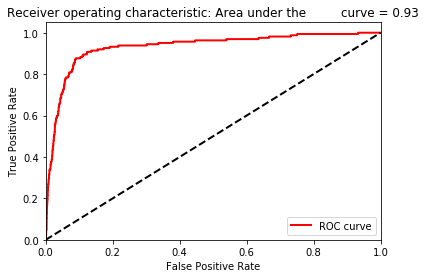

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.1162 - acc: 0.9276 - val_loss: 0.0389 - val_acc: 0.9898
Epoch 2/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.0313 - acc: 0.9853 - val_loss: 0.0226 - val_acc: 0.9925
Epoch 3/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.0223 - acc: 0.9830 - val_loss: 0.0199 - val_acc: 0.9770
Epoch 4/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.0198 - acc: 0.9790 - val_loss: 0.0270 - val_acc: 0.9353
Epoch 5/10
190820/190820 [==============================] - 36s 186us/step - loss: 0.0202 - acc: 0.9796 - val_loss: 0.0140 - val_acc: 0.9913
Epoch 6/10
190820/190820 [==============================] - 67s 353us/step - loss: 0.0180 - acc: 0.9858 - val_loss: 0.0127 - val_acc: 0.9945
Epoch 7/10
190820/190820 [==============================] - 44s 232us/step - loss: 0.0188 - acc: 0.978

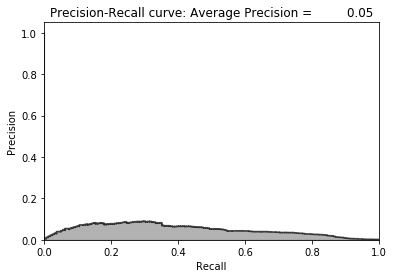

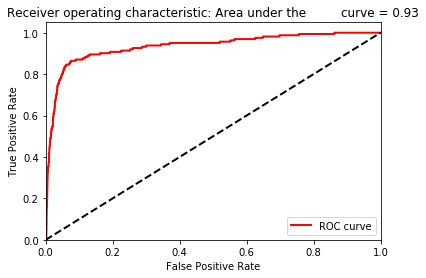

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 40s 212us/step - loss: 0.1309 - acc: 0.9116 - val_loss: 0.0424 - val_acc: 0.9880
Epoch 2/10
190820/190820 [==============================] - 55s 287us/step - loss: 0.0337 - acc: 0.9829 - val_loss: 0.0240 - val_acc: 0.9889
Epoch 3/10
190820/190820 [==============================] - 37s 195us/step - loss: 0.0238 - acc: 0.9822 - val_loss: 0.0177 - val_acc: 0.9959
Epoch 4/10
190820/190820 [==============================] - 31s 160us/step - loss: 0.0201 - acc: 0.9828 - val_loss: 0.0150 - val_acc: 0.9957
Epoch 5/10
190820/190820 [==============================] - 62s 324us/step - loss: 0.0181 - acc: 0.9771 - val_loss: 0.0181 - val_acc: 0.9888
Epoch 6/10
190820/190820 [==============================] - 33s 171us/step - loss: 0.0175 - acc: 0.9796 - val_loss: 0.0121 - val_acc: 0.9960
Epoch 7/10
190820/190820 [==============================] - 55s 288us/step - loss: 0.0163 - acc: 0.980

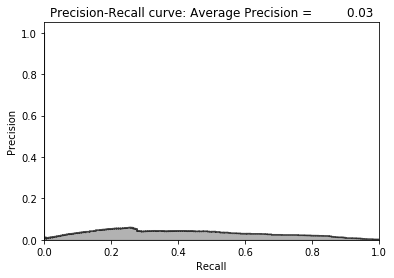

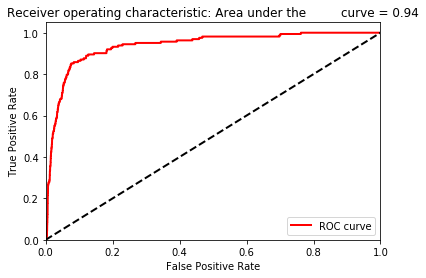

Mean average precision over 10 runs:  0.21373659011504448


[0.1370972172100049,
 0.28328895710699215,
 0.6362677613798704,
 0.3467265637372019,
 0.5197889253491589,
 0.01871495737323161,
 0.0812609121251577,
 0.034749761900336684,
 0.04846036143317335,
 0.031010483535317393]

In [20]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [21]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.21373659011504448
Coefficient of variation over 10 runs:  0.9913040763536749


[0.1370972172100049,
 0.28328895710699215,
 0.6362677613798704,
 0.3467265637372019,
 0.5197889253491589,
 0.01871495737323161,
 0.0812609121251577,
 0.034749761900336684,
 0.04846036143317335,
 0.031010483535317393]

In [22]:
# Model eight
# Two layer sparse overcomplete autoencoder with linear activation and dropout
# 29 -> 40 -> 29
# Dropout percentage: 5%

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 162us/step - loss: 0.1477 - acc: 0.8150 - val_loss: 0.0506 - val_acc: 0.9727
Epoch 2/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.0756 - acc: 0.8625 - val_loss: 0.0344 - val_acc: 0.9788
Epoch 3/10
190820/190820 [==============================] - 29s 152us/step - loss: 0.0687 - acc: 0.8612 - val_loss: 0.0291 - val_acc: 0.9790
Epoch 4/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.0644 - acc: 0.8606 - val_loss: 0.0274 - val_acc: 0.9734
Epoch 5/10
190820/190820 [==============================] - 31s 163us/step - loss: 0.0630 - acc: 0.8597 - val_loss: 0.0242 - val_acc: 0.9746
Epoch 6/10
190820/190820 [==============================] - 31s 162us/step - loss: 0.0609 - acc: 0.8600 - val_loss: 0.0220 - val_acc: 0.9800
Epoch 7/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.0624 - acc: 0.858

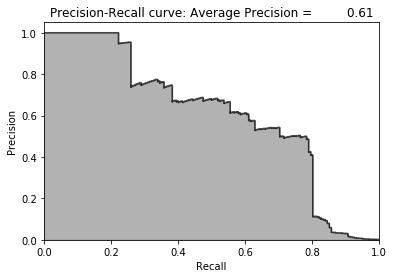

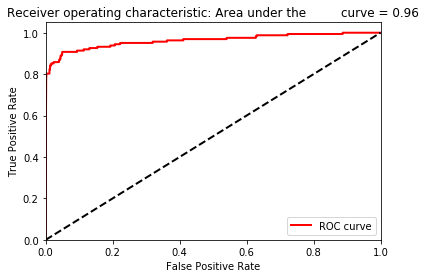

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 164us/step - loss: 0.1578 - acc: 0.8067 - val_loss: 0.0476 - val_acc: 0.9804
Epoch 2/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.0753 - acc: 0.8635 - val_loss: 0.0351 - val_acc: 0.9737
Epoch 3/10
190820/190820 [==============================] - 30s 160us/step - loss: 0.0687 - acc: 0.8605 - val_loss: 0.0282 - val_acc: 0.9836
Epoch 4/10
190820/190820 [==============================] - 32s 166us/step - loss: 0.0653 - acc: 0.8604 - val_loss: 0.0261 - val_acc: 0.9693
Epoch 5/10
190820/190820 [==============================] - 31s 162us/step - loss: 0.0629 - acc: 0.8597 - val_loss: 0.0270 - val_acc: 0.9824
Epoch 6/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.0614 - acc: 0.8595 - val_loss: 0.0234 - val_acc: 0.9731
Epoch 7/10
190820/190820 [==============================] - 63s 330us/step - loss: 0.0607 - acc: 0.859

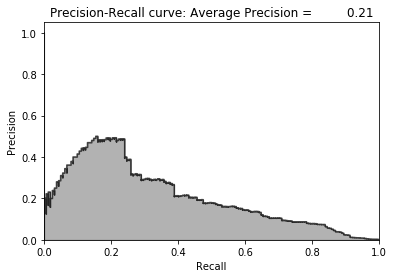

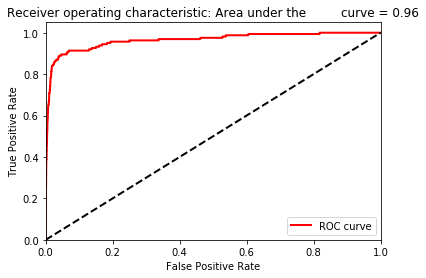

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 49s 254us/step - loss: 0.1984 - acc: 0.7866 - val_loss: 0.0533 - val_acc: 0.9769
Epoch 2/10
190820/190820 [==============================] - 31s 162us/step - loss: 0.0796 - acc: 0.8624 - val_loss: 0.0365 - val_acc: 0.9821
Epoch 3/10
190820/190820 [==============================] - 30s 160us/step - loss: 0.0704 - acc: 0.8629 - val_loss: 0.0299 - val_acc: 0.9843
Epoch 4/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.0656 - acc: 0.8610 - val_loss: 0.0317 - val_acc: 0.9638
Epoch 5/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.0649 - acc: 0.8611 - val_loss: 0.0251 - val_acc: 0.9768
Epoch 6/10
190820/190820 [==============================] - 30s 157us/step - loss: 0.0623 - acc: 0.8603 - val_loss: 0.0244 - val_acc: 0.9763
Epoch 7/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.0607 - acc: 0.861

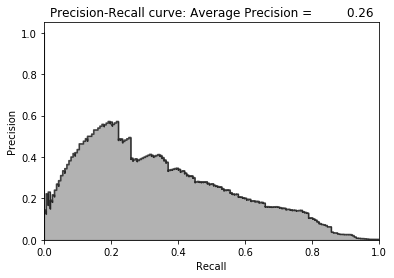

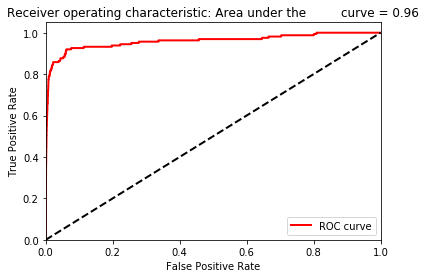

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 161us/step - loss: 0.1622 - acc: 0.8101 - val_loss: 0.0507 - val_acc: 0.9826
Epoch 2/10
190820/190820 [==============================] - 29s 153us/step - loss: 0.0777 - acc: 0.8625 - val_loss: 0.0404 - val_acc: 0.9689
Epoch 3/10
190820/190820 [==============================] - 29s 155us/step - loss: 0.0688 - acc: 0.8627 - val_loss: 0.0293 - val_acc: 0.9766
Epoch 4/10
190820/190820 [==============================] - 29s 155us/step - loss: 0.0650 - acc: 0.8603 - val_loss: 0.0256 - val_acc: 0.9796
Epoch 5/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.0634 - acc: 0.8604 - val_loss: 0.0267 - val_acc: 0.9594
Epoch 6/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.0627 - acc: 0.8597 - val_loss: 0.0225 - val_acc: 0.9806
Epoch 7/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.0632 - acc: 0.860

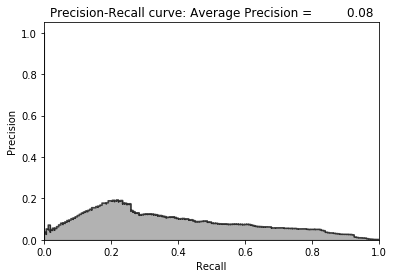

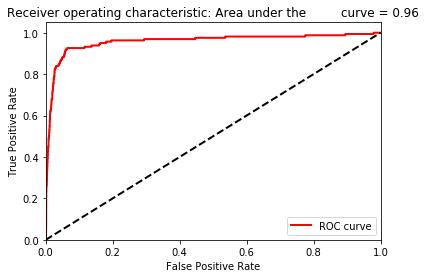

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 163us/step - loss: 0.1568 - acc: 0.8124 - val_loss: 0.0464 - val_acc: 0.9815
Epoch 2/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.0763 - acc: 0.8631 - val_loss: 0.0344 - val_acc: 0.9833
Epoch 3/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.0690 - acc: 0.8617 - val_loss: 0.0310 - val_acc: 0.9809
Epoch 4/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.0652 - acc: 0.8624 - val_loss: 0.0279 - val_acc: 0.9735
Epoch 5/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.0633 - acc: 0.8611 - val_loss: 0.0241 - val_acc: 0.9745
Epoch 6/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.0609 - acc: 0.8590 - val_loss: 0.0220 - val_acc: 0.9789
Epoch 7/10
190820/190820 [==============================] - 29s 154us/step - loss: 0.0609 - acc: 0.859

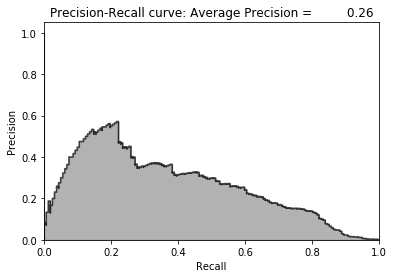

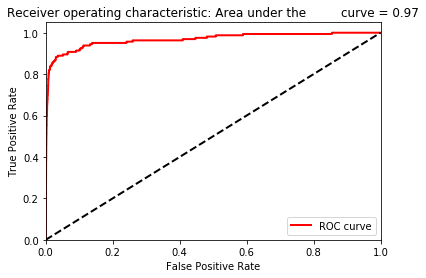

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 163us/step - loss: 0.1542 - acc: 0.8142 - val_loss: 0.0514 - val_acc: 0.9723
Epoch 2/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.0787 - acc: 0.8620 - val_loss: 0.0359 - val_acc: 0.9805
Epoch 3/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.0685 - acc: 0.8619 - val_loss: 0.0292 - val_acc: 0.9782
Epoch 4/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.0662 - acc: 0.8600 - val_loss: 0.0263 - val_acc: 0.9811
Epoch 5/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.0637 - acc: 0.8585 - val_loss: 0.0235 - val_acc: 0.9849
Epoch 6/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0608 - acc: 0.8598 - val_loss: 0.0275 - val_acc: 0.9625
Epoch 7/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0598 - acc: 0.860

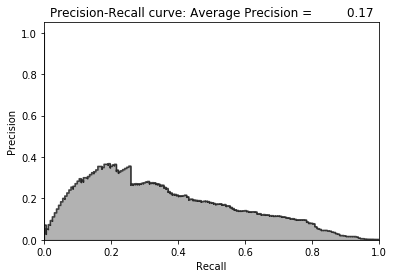

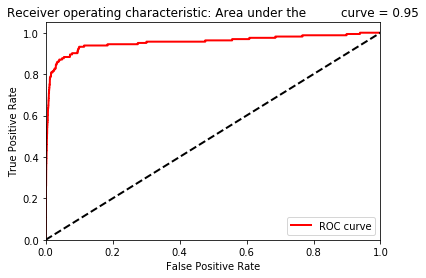

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.1678 - acc: 0.8089 - val_loss: 0.0501 - val_acc: 0.9798
Epoch 2/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0783 - acc: 0.8628 - val_loss: 0.0367 - val_acc: 0.9813
Epoch 3/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0684 - acc: 0.8621 - val_loss: 0.0317 - val_acc: 0.9716
Epoch 4/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0644 - acc: 0.8607 - val_loss: 0.0255 - val_acc: 0.9800
Epoch 5/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0642 - acc: 0.8599 - val_loss: 0.0247 - val_acc: 0.9813
Epoch 6/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0613 - acc: 0.8610 - val_loss: 0.0219 - val_acc: 0.9796
Epoch 7/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.0605 - acc: 0.860

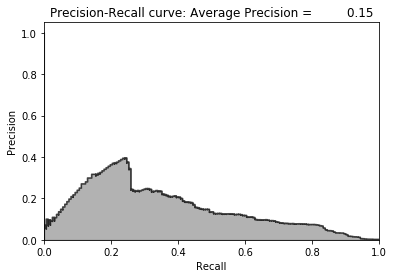

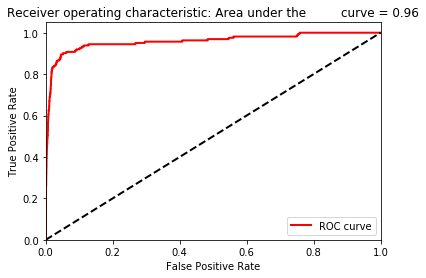

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.1727 - acc: 0.8056 - val_loss: 0.0508 - val_acc: 0.9801
Epoch 2/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0799 - acc: 0.8632 - val_loss: 0.0380 - val_acc: 0.9778
Epoch 3/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0708 - acc: 0.8625 - val_loss: 0.0314 - val_acc: 0.9741
Epoch 4/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0651 - acc: 0.8618 - val_loss: 0.0260 - val_acc: 0.9795
Epoch 5/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0637 - acc: 0.8616 - val_loss: 0.0295 - val_acc: 0.9594
Epoch 6/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0636 - acc: 0.8599 - val_loss: 0.0226 - val_acc: 0.9810
Epoch 7/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0601 - acc: 0.861

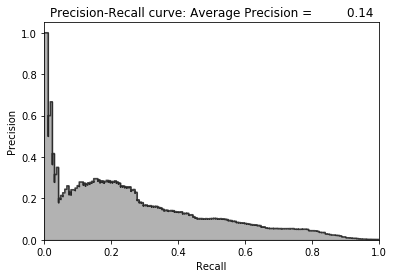

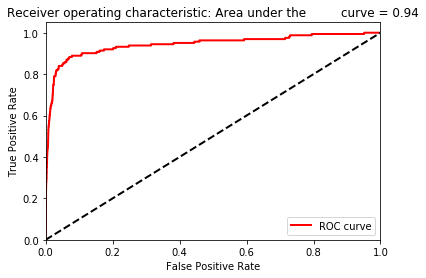

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.1614 - acc: 0.8117 - val_loss: 0.0507 - val_acc: 0.9750
Epoch 2/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0781 - acc: 0.8645 - val_loss: 0.0390 - val_acc: 0.9691
Epoch 3/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0698 - acc: 0.8627 - val_loss: 0.0306 - val_acc: 0.9706
Epoch 4/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0643 - acc: 0.8617 - val_loss: 0.0272 - val_acc: 0.9774
Epoch 5/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0631 - acc: 0.8613 - val_loss: 0.0238 - val_acc: 0.9787
Epoch 6/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.0616 - acc: 0.8610 - val_loss: 0.0256 - val_acc: 0.9657
Epoch 7/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0617 - acc: 0.860

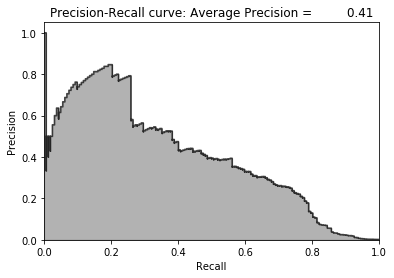

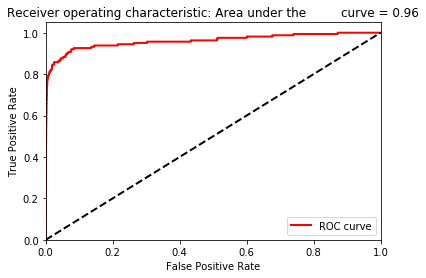

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.1650 - acc: 0.8082 - val_loss: 0.0497 - val_acc: 0.9807
Epoch 2/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0775 - acc: 0.8641 - val_loss: 0.0355 - val_acc: 0.9811
Epoch 3/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0698 - acc: 0.8626 - val_loss: 0.0308 - val_acc: 0.9749
Epoch 4/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0639 - acc: 0.8641 - val_loss: 0.0333 - val_acc: 0.9573
Epoch 5/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.0643 - acc: 0.8613 - val_loss: 0.0246 - val_acc: 0.9763
Epoch 6/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0604 - acc: 0.8607 - val_loss: 0.0223 - val_acc: 0.9795
Epoch 7/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0611 - acc: 0.859

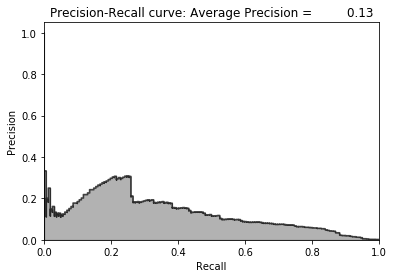

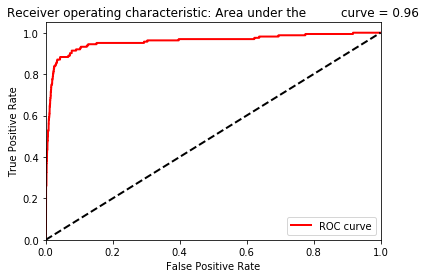

Mean average precision over 10 runs:  0.2426994231628755


[0.6078198313533932,
 0.20862366991302814,
 0.25854513247057875,
 0.08496595007072019,
 0.26313491674585093,
 0.17001322998258625,
 0.15338215561753896,
 0.1439107390306835,
 0.4073422280287587,
 0.1292563784156162]

In [23]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [24]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.2426994231628755
Coefficient of variation over 10 runs:  0.6153219870606188


[0.6078198313533932,
 0.20862366991302814,
 0.25854513247057875,
 0.08496595007072019,
 0.26313491674585093,
 0.17001322998258625,
 0.15338215561753896,
 0.1439107390306835,
 0.4073422280287587,
 0.1292563784156162]

In [ ]:
# Model nine
# Two layer denoising undercomplete autoencoder with linear activation
# 29 -> 27 -> 29

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.1733 - acc: 0.7756 - val_loss: 0.0356 - val_acc: 0.9123
Epoch 2/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.0546 - acc: 0.8793 - val_loss: 0.0354 - val_acc: 0.8973
Epoch 3/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.0531 - acc: 0.8764 - val_loss: 0.0350 - val_acc: 0.9399
Epoch 4/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.0525 - acc: 0.8879 - val_loss: 0.0342 - val_acc: 0.9573
Epoch 5/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.0530 - acc: 0.8910 - val_loss: 0.0347 - val_acc: 0.9503
Epoch 6/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.0524 - acc: 0.8889 - val_loss: 0.0350 - val_acc: 0.9138
Epoch 7/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.0531 - acc: 0.884

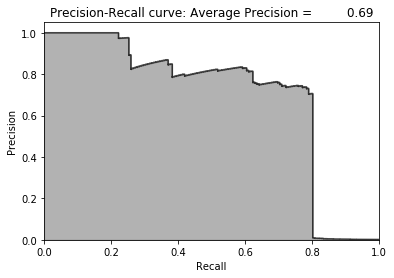

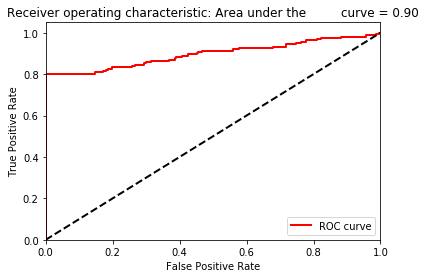

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.1507 - acc: 0.7605 - val_loss: 0.0372 - val_acc: 0.8788
Epoch 2/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.0576 - acc: 0.8626 - val_loss: 0.0366 - val_acc: 0.9198
Epoch 3/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.0562 - acc: 0.8792 - val_loss: 0.0370 - val_acc: 0.9339
Epoch 4/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0574 - acc: 0.8957 - val_loss: 0.0365 - val_acc: 0.9390
Epoch 5/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0558 - acc: 0.8885 - val_loss: 0.0368 - val_acc: 0.9551
Epoch 6/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.0574 - acc: 0.9037 - val_loss: 0.0367 - val_acc: 0.9560
Epoch 7/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.0568 - acc: 0.901

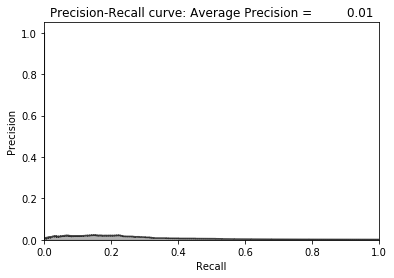

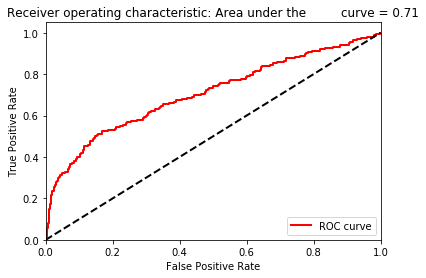

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.1494 - acc: 0.8033 - val_loss: 0.0364 - val_acc: 0.9040
Epoch 2/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0556 - acc: 0.8731 - val_loss: 0.0357 - val_acc: 0.9152
Epoch 3/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0544 - acc: 0.8807 - val_loss: 0.0353 - val_acc: 0.9167
Epoch 4/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0537 - acc: 0.8824 - val_loss: 0.0350 - val_acc: 0.9365
Epoch 5/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0551 - acc: 0.8883 - val_loss: 0.0345 - val_acc: 0.9409
Epoch 6/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0543 - acc: 0.8890 - val_loss: 0.0343 - val_acc: 0.9533
Epoch 7/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0542 - acc: 0.889

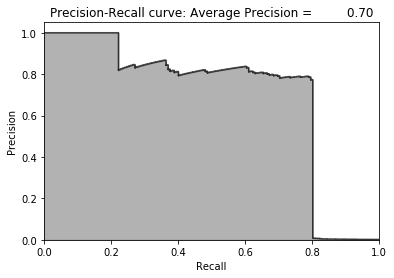

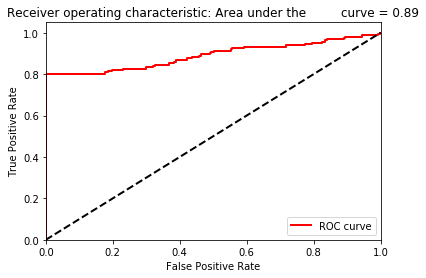

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 134us/step - loss: 0.1605 - acc: 0.7860 - val_loss: 0.0377 - val_acc: 0.9028
Epoch 2/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0589 - acc: 0.8546 - val_loss: 0.0378 - val_acc: 0.8882
Epoch 3/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0572 - acc: 0.8593 - val_loss: 0.0366 - val_acc: 0.9172
Epoch 4/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0568 - acc: 0.8895 - val_loss: 0.0364 - val_acc: 0.9391
Epoch 5/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0555 - acc: 0.8874 - val_loss: 0.0366 - val_acc: 0.9404
Epoch 6/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0565 - acc: 0.8979 - val_loss: 0.0368 - val_acc: 0.9453
Epoch 7/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0559 - acc: 0.901

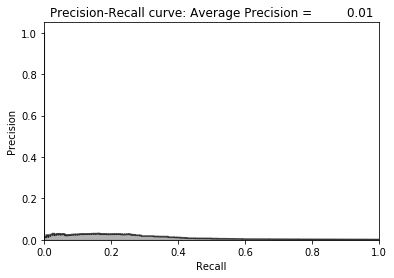

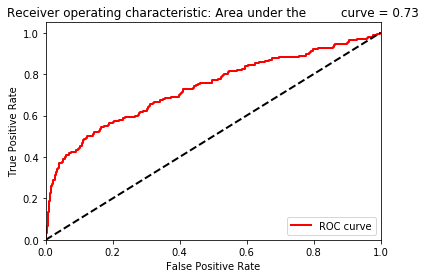

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 135us/step - loss: 0.1420 - acc: 0.7879 - val_loss: 0.0378 - val_acc: 0.9041
Epoch 2/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0569 - acc: 0.8829 - val_loss: 0.0369 - val_acc: 0.9256
Epoch 3/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0553 - acc: 0.8903 - val_loss: 0.0391 - val_acc: 0.9227
Epoch 4/10
190820/190820 [==============================] - 25s 128us/step - loss: 0.0564 - acc: 0.8744 - val_loss: 0.0380 - val_acc: 0.9134
Epoch 5/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0563 - acc: 0.8871 - val_loss: 0.0366 - val_acc: 0.9358
Epoch 6/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0562 - acc: 0.8933 - val_loss: 0.0373 - val_acc: 0.9335
Epoch 7/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0552 - acc: 0.893

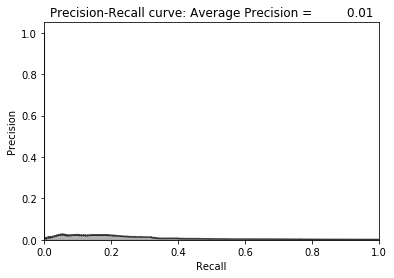

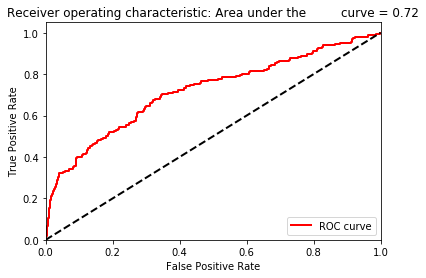

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.1368 - acc: 0.7908 - val_loss: 0.0359 - val_acc: 0.8937
Epoch 2/10
190820/190820 [==============================] - 25s 128us/step - loss: 0.0544 - acc: 0.8699 - val_loss: 0.0353 - val_acc: 0.9246
Epoch 3/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0569 - acc: 0.8951 - val_loss: 0.0359 - val_acc: 0.9402
Epoch 4/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0558 - acc: 0.9079 - val_loss: 0.0369 - val_acc: 0.9377
Epoch 5/10
190820/190820 [==============================] - 25s 128us/step - loss: 0.0562 - acc: 0.9040 - val_loss: 0.0391 - val_acc: 0.9442
Epoch 6/10
190820/190820 [==============================] - 25s 128us/step - loss: 0.0554 - acc: 0.9077 - val_loss: 0.0366 - val_acc: 0.9489
Epoch 7/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0551 - acc: 0.911

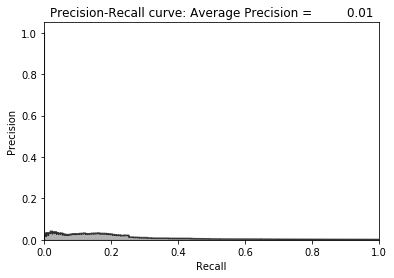

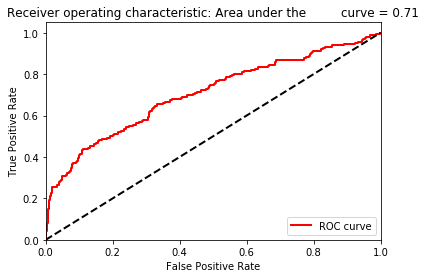

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.1357 - acc: 0.7940 - val_loss: 0.0363 - val_acc: 0.8954
Epoch 2/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0541 - acc: 0.8608 - val_loss: 0.0347 - val_acc: 0.9198
Epoch 3/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0530 - acc: 0.8877 - val_loss: 0.0366 - val_acc: 0.9324
Epoch 4/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0533 - acc: 0.8857 - val_loss: 0.0341 - val_acc: 0.9482
Epoch 5/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0524 - acc: 0.8879 - val_loss: 0.0344 - val_acc: 0.9496
Epoch 6/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0528 - acc: 0.8899 - val_loss: 0.0343 - val_acc: 0.9496
Epoch 7/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0523 - acc: 0.886

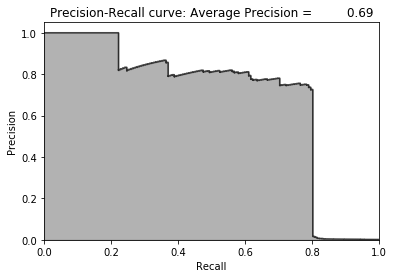

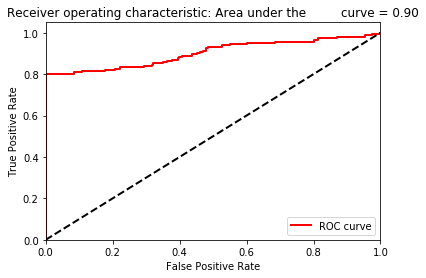

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.1329 - acc: 0.7933 - val_loss: 0.0360 - val_acc: 0.8756
Epoch 2/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0575 - acc: 0.8848 - val_loss: 0.0370 - val_acc: 0.9415
Epoch 3/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0567 - acc: 0.8865 - val_loss: 0.0370 - val_acc: 0.9350
Epoch 4/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0557 - acc: 0.8903 - val_loss: 0.0363 - val_acc: 0.9485
Epoch 5/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.0558 - acc: 0.9007 - val_loss: 0.0365 - val_acc: 0.9475
Epoch 6/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0568 - acc: 0.9009 - val_loss: 0.0367 - val_acc: 0.9498
Epoch 7/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.0557 - acc: 0.898

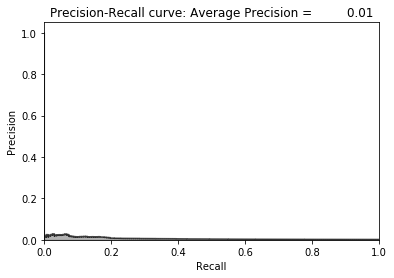

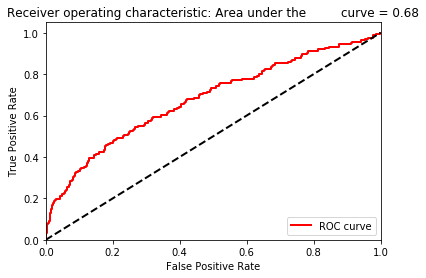

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.1539 - acc: 0.7756 - val_loss: 0.0359 - val_acc: 0.8616
Epoch 2/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0544 - acc: 0.8512 - val_loss: 0.0354 - val_acc: 0.9197
Epoch 3/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0546 - acc: 0.8776 - val_loss: 0.0346 - val_acc: 0.9285
Epoch 4/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0538 - acc: 0.8821 - val_loss: 0.0344 - val_acc: 0.9220
Epoch 5/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0534 - acc: 0.8775 - val_loss: 0.0346 - val_acc: 0.9503
Epoch 6/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0520 - acc: 0.8898 - val_loss: 0.0339 - val_acc: 0.9568
Epoch 7/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0535 - acc: 0.889

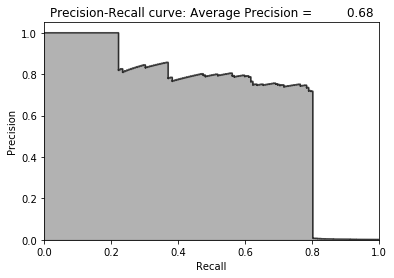

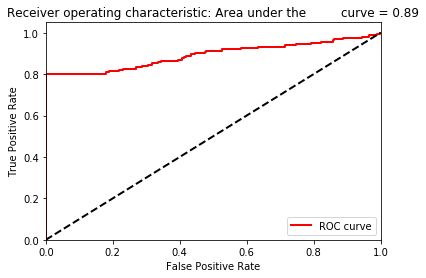

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 139us/step - loss: 0.1381 - acc: 0.8147 - val_loss: 0.0379 - val_acc: 0.9285
Epoch 2/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0573 - acc: 0.8906 - val_loss: 0.0379 - val_acc: 0.9327
Epoch 3/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0565 - acc: 0.8882 - val_loss: 0.0368 - val_acc: 0.9471
Epoch 4/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0565 - acc: 0.9031 - val_loss: 0.0368 - val_acc: 0.9546
Epoch 5/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0553 - acc: 0.9056 - val_loss: 0.0370 - val_acc: 0.9644
Epoch 6/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0563 - acc: 0.9127 - val_loss: 0.0366 - val_acc: 0.9639
Epoch 7/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0567 - acc: 0.912

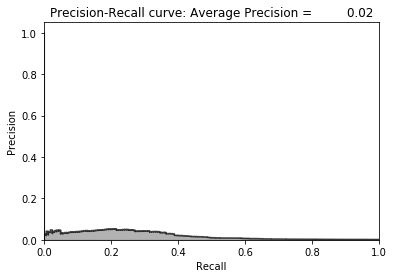

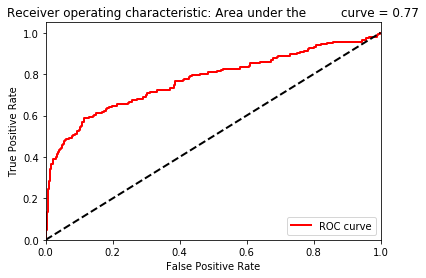

Mean average precision over 10 runs:  0.2825997155005206


[0.6929639885685303,
 0.008450118408150287,
 0.6970753417267612,
 0.011820311633718597,
 0.008924124892696377,
 0.010639537507746342,
 0.6884911855668772,
 0.006549332886020607,
 0.6805304226634528,
 0.02055279115125298]

In [25]:
# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 27 nodes using linear activation
    model.add(Dense(units=27, activation='linear', input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [26]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.2825997155005206
Coefficient of variation over 10 runs:  1.1765416185187383


[0.6929639885685303,
 0.008450118408150287,
 0.6970753417267612,
 0.011820311633718597,
 0.008924124892696377,
 0.010639537507746342,
 0.6884911855668772,
 0.006549332886020607,
 0.6805304226634528,
 0.02055279115125298]

In [ ]:
# Model ten
# Two layer denoising overcomplete autoencoder with linear activation
# And sparsity regularizer and dropout
# 29 -> 40 -> 29
# Dropout percentage: 5%

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1726 - acc: 0.8035 - val_loss: 0.0432 - val_acc: 0.9781
Epoch 2/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0868 - acc: 0.8490 - val_loss: 0.0307 - val_acc: 0.9775
Epoch 3/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0809 - acc: 0.8455 - val_loss: 0.0445 - val_acc: 0.9535
Epoch 4/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0777 - acc: 0.8438 - val_loss: 0.0257 - val_acc: 0.9709
Epoch 5/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0748 - acc: 0.8434 - val_loss: 0.0219 - val_acc: 0.9787
Epoch 6/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0746 - acc: 0.8425 - val_loss: 0.0210 - val_acc: 0.9794
Epoch 7/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0713 - acc: 0.843

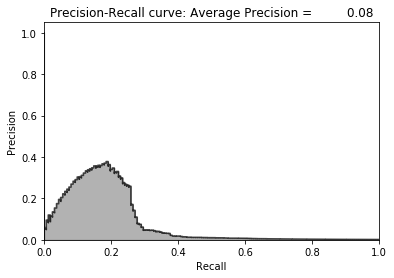

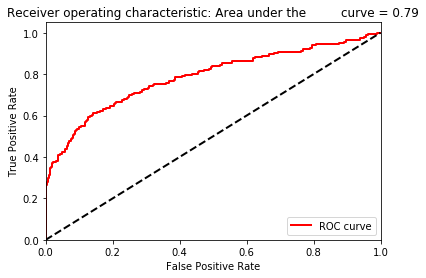

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.2004 - acc: 0.7929 - val_loss: 0.0486 - val_acc: 0.9838
Epoch 2/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.0914 - acc: 0.8469 - val_loss: 0.0327 - val_acc: 0.9848
Epoch 3/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0823 - acc: 0.8451 - val_loss: 0.0285 - val_acc: 0.9795
Epoch 4/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.0763 - acc: 0.8457 - val_loss: 0.0277 - val_acc: 0.9609
Epoch 5/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.0751 - acc: 0.8438 - val_loss: 0.0277 - val_acc: 0.9645
Epoch 6/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.0727 - acc: 0.8433 - val_loss: 0.0638 - val_acc: 0.9305
Epoch 7/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.0726 - acc: 0.843

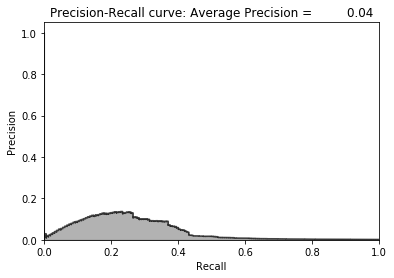

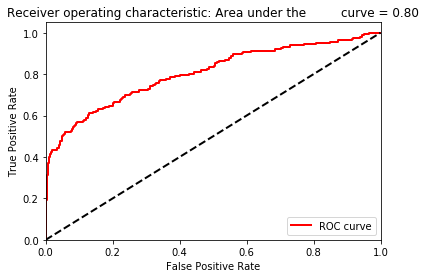

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1938 - acc: 0.7941 - val_loss: 0.0557 - val_acc: 0.9643
Epoch 2/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0893 - acc: 0.8479 - val_loss: 0.0324 - val_acc: 0.9805
Epoch 3/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0814 - acc: 0.8464 - val_loss: 0.0270 - val_acc: 0.9853
Epoch 4/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0782 - acc: 0.8451 - val_loss: 0.0277 - val_acc: 0.9672
Epoch 5/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0743 - acc: 0.8448 - val_loss: 0.0238 - val_acc: 0.9742
Epoch 6/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0732 - acc: 0.8445 - val_loss: 0.0237 - val_acc: 0.9648
Epoch 7/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0716 - acc: 0.844

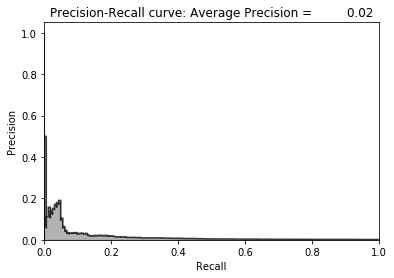

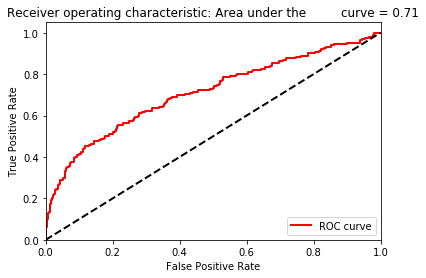

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.1838 - acc: 0.7972 - val_loss: 0.0478 - val_acc: 0.9753
Epoch 2/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0892 - acc: 0.8480 - val_loss: 0.0324 - val_acc: 0.9841
Epoch 3/10
190820/190820 [==============================] - 26s 139us/step - loss: 0.0798 - acc: 0.8463 - val_loss: 0.0271 - val_acc: 0.9807
Epoch 4/10
190820/190820 [==============================] - 26s 139us/step - loss: 0.0764 - acc: 0.8459 - val_loss: 0.0241 - val_acc: 0.9762
Epoch 5/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0741 - acc: 0.8443 - val_loss: 0.0222 - val_acc: 0.9756
Epoch 6/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0720 - acc: 0.8452 - val_loss: 0.0227 - val_acc: 0.9593
Epoch 7/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0716 - acc: 0.844

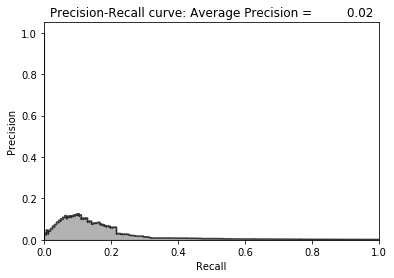

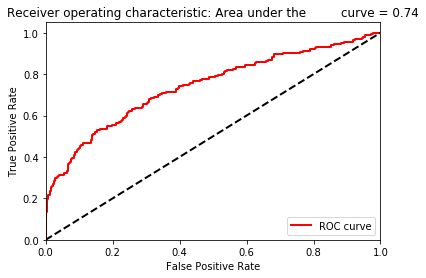

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.1969 - acc: 0.7939 - val_loss: 0.0474 - val_acc: 0.9840
Epoch 2/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0907 - acc: 0.8473 - val_loss: 0.0327 - val_acc: 0.9849
Epoch 3/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0814 - acc: 0.8472 - val_loss: 0.0275 - val_acc: 0.9787
Epoch 4/10
190820/190820 [==============================] - 26s 139us/step - loss: 0.0766 - acc: 0.8454 - val_loss: 0.0255 - val_acc: 0.9663
Epoch 5/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0743 - acc: 0.8445 - val_loss: 0.0227 - val_acc: 0.9775
Epoch 6/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0718 - acc: 0.8424 - val_loss: 0.0231 - val_acc: 0.9759
Epoch 7/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0727 - acc: 0.843

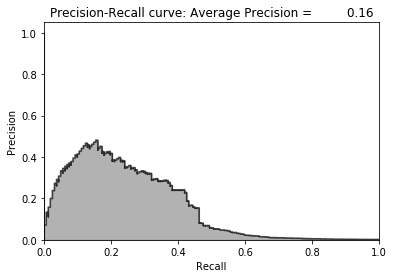

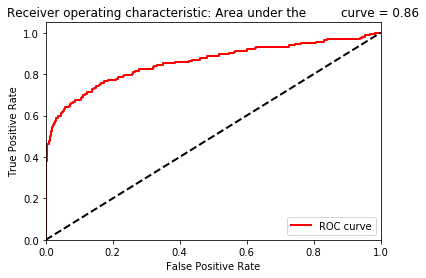

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.1686 - acc: 0.8045 - val_loss: 0.0428 - val_acc: 0.9811
Epoch 2/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0883 - acc: 0.8473 - val_loss: 0.0316 - val_acc: 0.9806
Epoch 3/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0810 - acc: 0.8465 - val_loss: 0.0270 - val_acc: 0.9737
Epoch 4/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0765 - acc: 0.8468 - val_loss: 0.0260 - val_acc: 0.9742
Epoch 5/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0764 - acc: 0.8456 - val_loss: 0.0217 - val_acc: 0.9824
Epoch 6/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0748 - acc: 0.8427 - val_loss: 0.0230 - val_acc: 0.9761
Epoch 7/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0733 - acc: 0.844

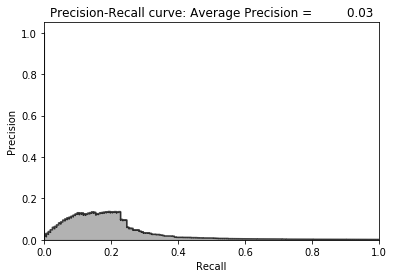

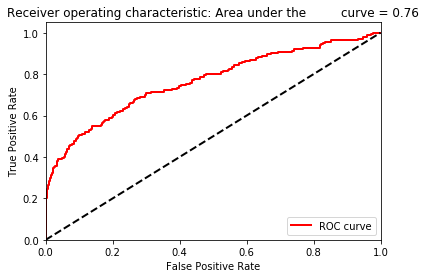

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.2009 - acc: 0.7848 - val_loss: 0.0474 - val_acc: 0.9840
Epoch 2/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0917 - acc: 0.8480 - val_loss: 0.0342 - val_acc: 0.9771
Epoch 3/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0814 - acc: 0.8483 - val_loss: 0.0309 - val_acc: 0.9640
Epoch 4/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0772 - acc: 0.8472 - val_loss: 0.0238 - val_acc: 0.9854
Epoch 5/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0751 - acc: 0.8457 - val_loss: 0.0219 - val_acc: 0.9827
Epoch 6/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0729 - acc: 0.8447 - val_loss: 0.0208 - val_acc: 0.9819
Epoch 7/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0713 - acc: 0.843

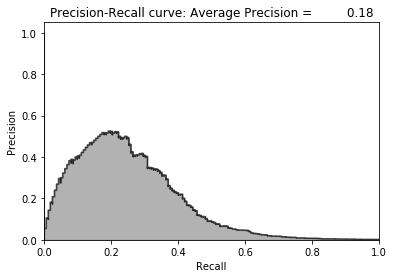

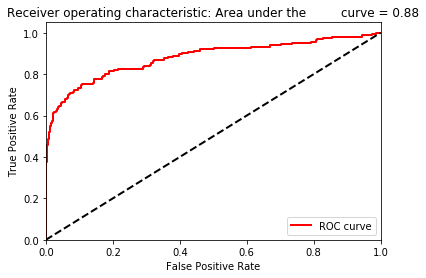

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 29s 150us/step - loss: 0.2173 - acc: 0.7772 - val_loss: 0.0481 - val_acc: 0.9840
Epoch 2/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0923 - acc: 0.8473 - val_loss: 0.0355 - val_acc: 0.9736
Epoch 3/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0798 - acc: 0.8488 - val_loss: 0.0283 - val_acc: 0.9739
Epoch 4/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0777 - acc: 0.8448 - val_loss: 0.0240 - val_acc: 0.9798
Epoch 5/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0744 - acc: 0.8459 - val_loss: 0.0226 - val_acc: 0.9803
Epoch 6/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.0730 - acc: 0.8447 - val_loss: 0.0204 - val_acc: 0.9809
Epoch 7/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0733 - acc: 0.844

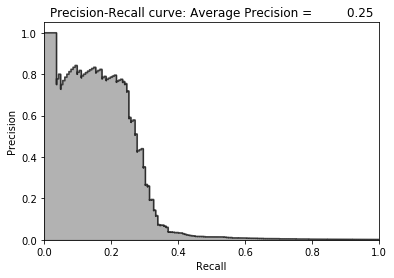

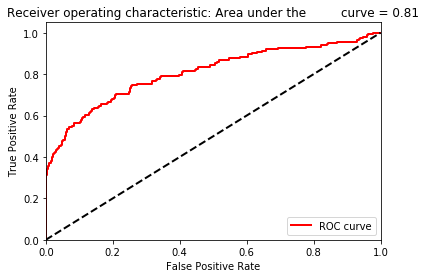

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 29s 150us/step - loss: 0.2251 - acc: 0.7761 - val_loss: 0.0540 - val_acc: 0.9644
Epoch 2/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0928 - acc: 0.8466 - val_loss: 0.0336 - val_acc: 0.9834
Epoch 3/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0817 - acc: 0.8461 - val_loss: 0.0287 - val_acc: 0.9743
Epoch 4/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0780 - acc: 0.8454 - val_loss: 0.0272 - val_acc: 0.9701
Epoch 5/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.0746 - acc: 0.8453 - val_loss: 0.0221 - val_acc: 0.9766
Epoch 6/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0729 - acc: 0.8434 - val_loss: 0.0220 - val_acc: 0.9755
Epoch 7/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0716 - acc: 0.843

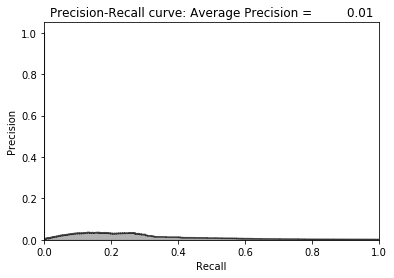

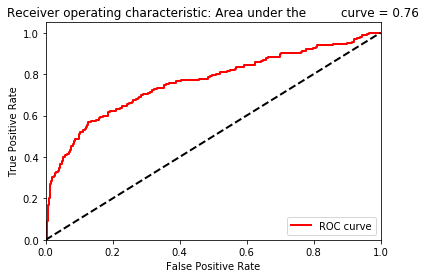

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 29s 152us/step - loss: 0.1741 - acc: 0.8024 - val_loss: 0.0450 - val_acc: 0.9840
Epoch 2/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.0912 - acc: 0.8457 - val_loss: 0.0343 - val_acc: 0.9800
Epoch 3/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.0808 - acc: 0.8470 - val_loss: 0.0273 - val_acc: 0.9803
Epoch 4/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.0762 - acc: 0.8454 - val_loss: 0.0263 - val_acc: 0.9677
Epoch 5/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.0743 - acc: 0.8437 - val_loss: 0.0236 - val_acc: 0.9769
Epoch 6/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.0745 - acc: 0.8439 - val_loss: 0.0211 - val_acc: 0.9758
Epoch 7/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.0709 - acc: 0.843

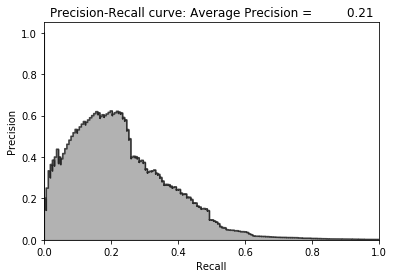

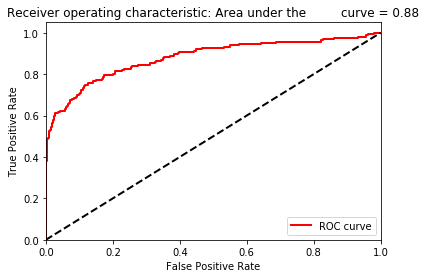

Mean average precision over 10 runs:  0.10112931070692295


[0.08283546387140524,
 0.043070120657586454,
 0.018901753737287603,
 0.02381040174486509,
 0.16038446580196433,
 0.03461061251209459,
 0.17847771715513427,
 0.2483282420447288,
 0.012981344347664117,
 0.20789298519649893]

In [27]:
# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [28]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.10112931070692295
Coefficient of variation over 10 runs:  0.8343774832756188


[0.08283546387140524,
 0.043070120657586454,
 0.018901753737287603,
 0.02381040174486509,
 0.16038446580196433,
 0.03461061251209459,
 0.17847771715513427,
 0.2483282420447288,
 0.012981344347664117,
 0.20789298519649893]

In [ ]:
# Model eleven
# Two layer denoising overcomplete autoencoder with ReLU activation
# And sparsity regularizer and dropout
# 29 -> 40 -> 29
# Dropout percentage: 5%

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 29s 153us/step - loss: 0.3049 - acc: 0.6454 - val_loss: 0.0841 - val_acc: 0.8873
Epoch 2/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.1806 - acc: 0.7193 - val_loss: 0.0606 - val_acc: 0.9012
Epoch 3/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.1626 - acc: 0.7255 - val_loss: 0.0500 - val_acc: 0.9045
Epoch 4/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.1567 - acc: 0.7294 - val_loss: 0.0445 - val_acc: 0.9116
Epoch 5/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.1484 - acc: 0.7309 - val_loss: 0.0433 - val_acc: 0.9136
Epoch 6/10
190820/190820 [==============================] - 27s 144us/step - loss: 0.1467 - acc: 0.7311 - val_loss: 0.0375 - val_acc: 0.9101
Epoch 7/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.1427 - acc: 0.733

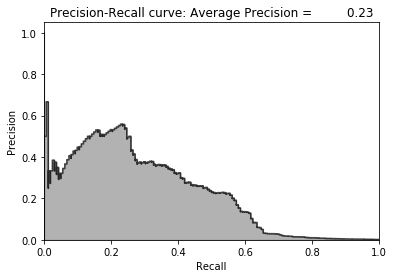

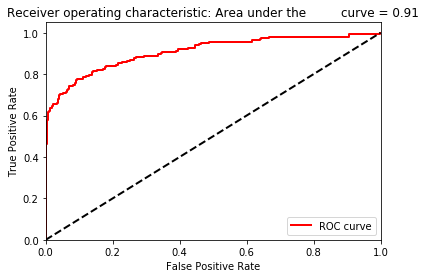

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 29s 153us/step - loss: 0.3206 - acc: 0.6336 - val_loss: 0.0859 - val_acc: 0.8825
Epoch 2/10
190820/190820 [==============================] - 27s 144us/step - loss: 0.1846 - acc: 0.7146 - val_loss: 0.0656 - val_acc: 0.8902
Epoch 3/10
190820/190820 [==============================] - 27s 144us/step - loss: 0.1650 - acc: 0.7214 - val_loss: 0.0512 - val_acc: 0.8997
Epoch 4/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1543 - acc: 0.7265 - val_loss: 0.0448 - val_acc: 0.9066
Epoch 5/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1449 - acc: 0.7276 - val_loss: 0.0429 - val_acc: 0.9014
Epoch 6/10
190820/190820 [==============================] - 27s 144us/step - loss: 0.1462 - acc: 0.7263 - val_loss: 0.0395 - val_acc: 0.9001
Epoch 7/10
190820/190820 [==============================] - 27s 144us/step - loss: 0.1437 - acc: 0.727

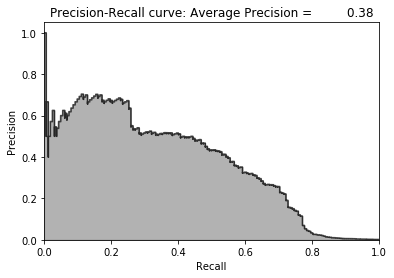

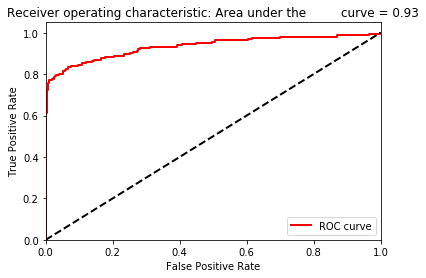

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 29s 153us/step - loss: 0.3004 - acc: 0.6426 - val_loss: 0.0814 - val_acc: 0.8848
Epoch 2/10
190820/190820 [==============================] - 28s 144us/step - loss: 0.1819 - acc: 0.7160 - val_loss: 0.0654 - val_acc: 0.8821
Epoch 3/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1642 - acc: 0.7197 - val_loss: 0.0501 - val_acc: 0.9060
Epoch 4/10
190820/190820 [==============================] - 28s 144us/step - loss: 0.1569 - acc: 0.7226 - val_loss: 0.0440 - val_acc: 0.9057
Epoch 5/10
190820/190820 [==============================] - 28s 144us/step - loss: 0.1507 - acc: 0.7230 - val_loss: 0.0408 - val_acc: 0.9096
Epoch 6/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1467 - acc: 0.7269 - val_loss: 0.0386 - val_acc: 0.9067
Epoch 7/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1430 - acc: 0.727

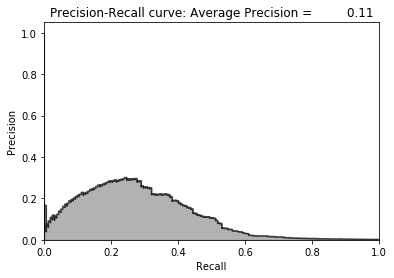

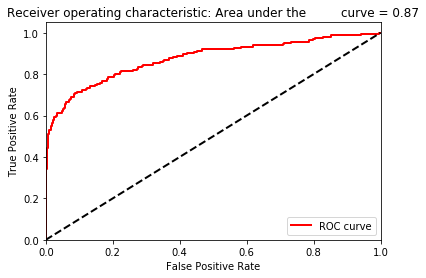

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.3005 - acc: 0.6438 - val_loss: 0.0854 - val_acc: 0.8824
Epoch 2/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1840 - acc: 0.7168 - val_loss: 0.0653 - val_acc: 0.8914
Epoch 3/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1651 - acc: 0.7232 - val_loss: 0.0520 - val_acc: 0.9085
Epoch 4/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1534 - acc: 0.7274 - val_loss: 0.0451 - val_acc: 0.9069
Epoch 5/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1488 - acc: 0.7306 - val_loss: 0.0421 - val_acc: 0.9099
Epoch 6/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1443 - acc: 0.7291 - val_loss: 0.0387 - val_acc: 0.9111
Epoch 7/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1409 - acc: 0.732

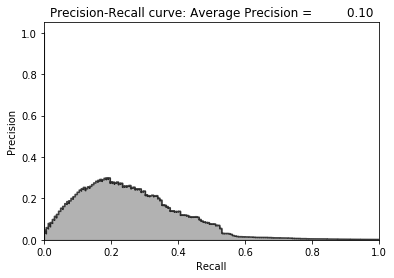

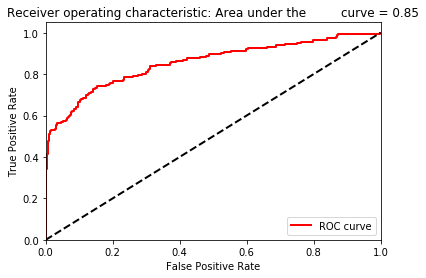

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.2995 - acc: 0.6440 - val_loss: 0.0847 - val_acc: 0.8887
Epoch 2/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1853 - acc: 0.7163 - val_loss: 0.0638 - val_acc: 0.8953
Epoch 3/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1670 - acc: 0.7217 - val_loss: 0.0536 - val_acc: 0.9037
Epoch 4/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1576 - acc: 0.7252 - val_loss: 0.0464 - val_acc: 0.9092
Epoch 5/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1500 - acc: 0.7280 - val_loss: 0.0428 - val_acc: 0.9094
Epoch 6/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1493 - acc: 0.7284 - val_loss: 0.0494 - val_acc: 0.8979
Epoch 7/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1444 - acc: 0.729

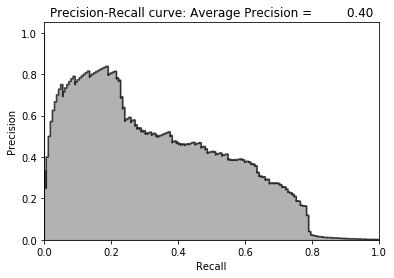

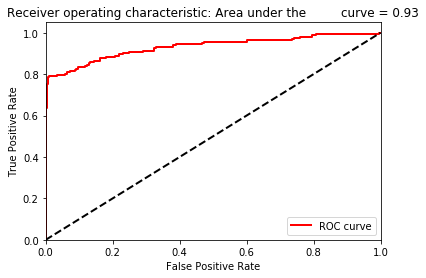

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.3035 - acc: 0.6415 - val_loss: 0.0839 - val_acc: 0.8875
Epoch 2/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1831 - acc: 0.7148 - val_loss: 0.0611 - val_acc: 0.8967
Epoch 3/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1655 - acc: 0.7211 - val_loss: 0.0518 - val_acc: 0.9077
Epoch 4/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1569 - acc: 0.7257 - val_loss: 0.0701 - val_acc: 0.8528
Epoch 5/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1497 - acc: 0.7283 - val_loss: 0.0462 - val_acc: 0.9054
Epoch 6/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1467 - acc: 0.7271 - val_loss: 0.0399 - val_acc: 0.9065
Epoch 7/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1452 - acc: 0.728

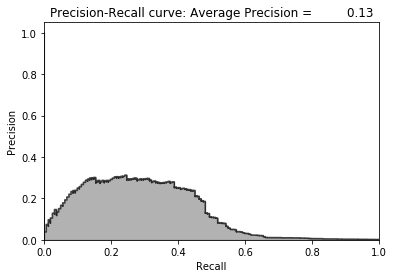

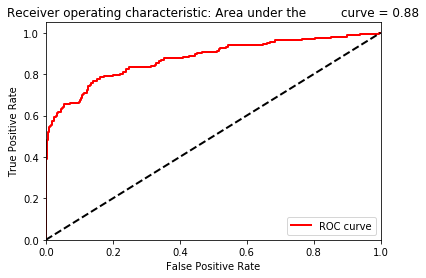

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.3076 - acc: 0.6407 - val_loss: 0.0905 - val_acc: 0.8724
Epoch 2/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1814 - acc: 0.7190 - val_loss: 0.0600 - val_acc: 0.9041
Epoch 3/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1633 - acc: 0.7265 - val_loss: 0.0552 - val_acc: 0.8932
Epoch 4/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1548 - acc: 0.7286 - val_loss: 0.0446 - val_acc: 0.9105
Epoch 5/10
190820/190820 [==============================] - 28s 147us/step - loss: 0.1501 - acc: 0.7299 - val_loss: 0.0417 - val_acc: 0.9116
Epoch 6/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1461 - acc: 0.7309 - val_loss: 0.0450 - val_acc: 0.8923
Epoch 7/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1426 - acc: 0.731

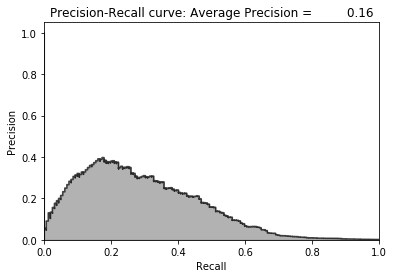

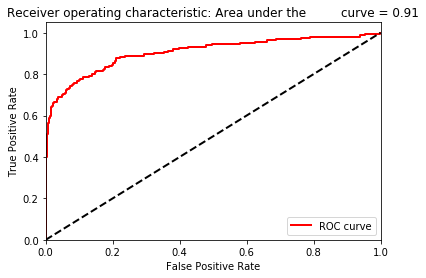

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.2942 - acc: 0.6471 - val_loss: 0.0823 - val_acc: 0.8883
Epoch 2/10
190820/190820 [==============================] - 28s 147us/step - loss: 0.1844 - acc: 0.7167 - val_loss: 0.0632 - val_acc: 0.9004
Epoch 3/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.1673 - acc: 0.7216 - val_loss: 0.0549 - val_acc: 0.8996
Epoch 4/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1564 - acc: 0.7239 - val_loss: 0.0453 - val_acc: 0.9091
Epoch 5/10
190820/190820 [==============================] - 28s 147us/step - loss: 0.1530 - acc: 0.7240 - val_loss: 0.0412 - val_acc: 0.9122
Epoch 6/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1482 - acc: 0.7275 - val_loss: 0.0399 - val_acc: 0.9060
Epoch 7/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1448 - acc: 0.728

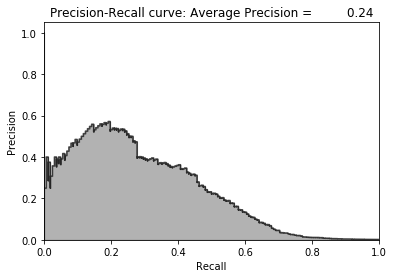

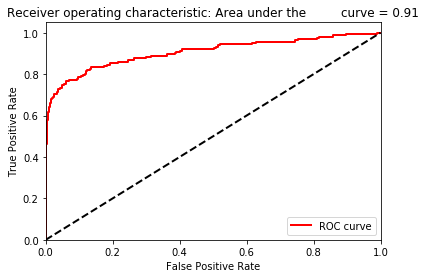

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 30s 157us/step - loss: 0.3061 - acc: 0.6407 - val_loss: 0.0838 - val_acc: 0.8829
Epoch 2/10
190820/190820 [==============================] - 28s 149us/step - loss: 0.1850 - acc: 0.7154 - val_loss: 0.0631 - val_acc: 0.8956
Epoch 3/10
190820/190820 [==============================] - 29s 150us/step - loss: 0.1673 - acc: 0.7211 - val_loss: 0.0549 - val_acc: 0.8925
Epoch 4/10
190820/190820 [==============================] - 30s 158us/step - loss: 0.1569 - acc: 0.7255 - val_loss: 0.0459 - val_acc: 0.9040
Epoch 5/10
190820/190820 [==============================] - 33s 172us/step - loss: 0.1522 - acc: 0.7278 - val_loss: 0.0409 - val_acc: 0.9126
Epoch 6/10
190820/190820 [==============================] - 36s 189us/step - loss: 0.1476 - acc: 0.7270 - val_loss: 0.0451 - val_acc: 0.8992
Epoch 7/10
190820/190820 [==============================] - 33s 174us/step - loss: 0.1444 - acc: 0.729

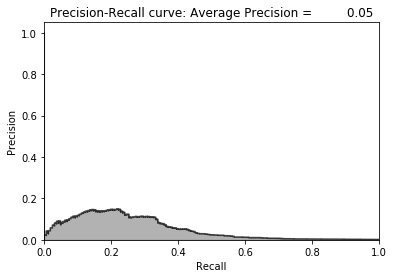

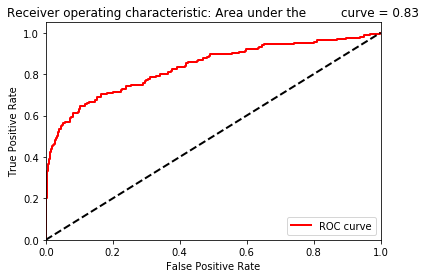

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 167us/step - loss: 0.2993 - acc: 0.6452 - val_loss: 0.0816 - val_acc: 0.8880
Epoch 2/10
190820/190820 [==============================] - 32s 168us/step - loss: 0.1829 - acc: 0.7169 - val_loss: 0.0603 - val_acc: 0.9052
Epoch 3/10
190820/190820 [==============================] - 33s 171us/step - loss: 0.1639 - acc: 0.7264 - val_loss: 0.0519 - val_acc: 0.9012
Epoch 4/10
190820/190820 [==============================] - 33s 171us/step - loss: 0.1552 - acc: 0.7292 - val_loss: 0.0435 - val_acc: 0.9159
Epoch 5/10
190820/190820 [==============================] - 33s 170us/step - loss: 0.1472 - acc: 0.7312 - val_loss: 0.0396 - val_acc: 0.9141
Epoch 6/10
190820/190820 [==============================] - 33s 175us/step - loss: 0.1436 - acc: 0.7336 - val_loss: 0.0369 - val_acc: 0.9159
Epoch 7/10
190820/190820 [==============================] - 33s 174us/step - loss: 0.1403 - acc: 0.734

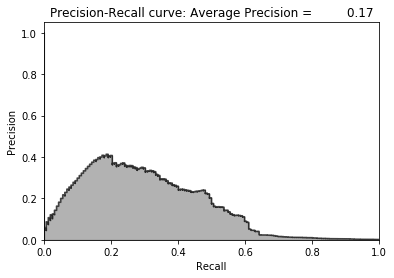

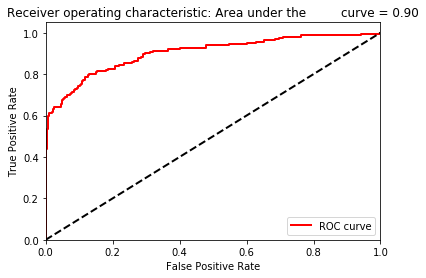

Mean average precision over 10 runs:  0.1969608394689088


[0.22960316854089222,
 0.37609633487223315,
 0.11429775486529765,
 0.10208135698072755,
 0.4002384343852861,
 0.13317480663248088,
 0.15764518571284625,
 0.2406315655171392,
 0.05080529996343734,
 0.1650344872187474]

In [29]:
# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='relu',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [30]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.1969608394689088
Coefficient of variation over 10 runs:  0.5566706365802669


[0.22960316854089222,
 0.37609633487223315,
 0.11429775486529765,
 0.10208135698072755,
 0.4002384343852861,
 0.13317480663248088,
 0.15764518571284625,
 0.2406315655171392,
 0.05080529996343734,
 0.1650344872187474]